# BGP Traffic Labeling Strategy Comparison

## Comprehensive Analysis of Different Labeling Approaches

**Author:** Shadi Motaali  
**Institution:** Universidad Autónoma de Madrid  
**Date:** November 2024

---

### Overview

This notebook compares **four different labeling strategies** for BGP anomaly detection:

1. **Conservative**: Labels as abnormal if ANY abnormal traffic exists in the window
2. **Majority**: Uses majority voting (most frequent label)
3. **Weighted (0.3)**: Labels as abnormal if >30% of window is abnormal
4. **Weighted (0.4)**: Labels as abnormal if >40% of window is abnormal

### Analysis Components:
- Label distribution analysis
- Inter-strategy agreement (Cohen's Kappa)
- Machine learning performance comparison
- Visual analysis (t-SNE)
- Recommendations for different use cases

## 1. Setup and Imports

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support,
                             cohen_kappa_score)
from sklearn.manifold import TSNE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✓ All packages imported successfully!")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ Scikit-learn version: {__import__('sklearn').__version__}")

✓ All packages imported successfully!
✓ NumPy version: 1.24.4
✓ Pandas version: 2.0.3
✓ Scikit-learn version: 1.3.2


## 2. Load Data

**Important**: Update the `DATA_DIR` variable to match your file locations.

In [2]:
# Configuration
DATA_DIR = '/home/smotaali/BGP_Traffic_Generation/results'  # Update this path
OUTPUT_DIR = '/home/smotaali/BGP_Traffic_Generation/results'  # Output directory for results

# Create output directory if it doesn't exist
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# File names
files = {
    'Conservative': '20251119_175149_exctracted_1s_conservative.csv',
    'Majority': '20251119_175149_exctracted_1s_majority.csv',
    'Weighted (0.3)': '20251119_175149_exctracted_1s_weighted_03.csv',
    'Weighted (0.4)': '20251119_175149_exctracted_1s_weighted_04.csv'
}

# Load datasets
print("Loading datasets...")
datasets = {}
for name, filename in files.items():
    filepath = os.path.join(DATA_DIR, filename)
    df = pd.read_csv(filepath)
    datasets[name] = df
    print(f"  ✓ {name:20s}: {df.shape[0]:,} samples, {df.shape[1]} features")

print("\n✓ All datasets loaded successfully!")

Loading datasets...
  ✓ Conservative        : 19,169 samples, 30 features
  ✓ Majority            : 19,169 samples, 30 features
  ✓ Weighted (0.3)      : 19,169 samples, 30 features
  ✓ Weighted (0.4)      : 19,169 samples, 30 features

✓ All datasets loaded successfully!


## 3. Data Overview

In [3]:
# Display first few rows of Conservative dataset
print("Sample data from Conservative strategy:")
display(datasets['Conservative'].head())

# Feature columns (exclude label and timestamp columns)
feature_cols = [col for col in datasets['Conservative'].columns 
                if col not in ['label', 'window_start', 'window_end']]

print(f"\nTotal features: {len(feature_cols)}")
print(f"Features: {', '.join(feature_cols[:10])}...")

Sample data from Conservative strategy:


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,as_path_max,unique_as_path_max,edit_distance_avg,...,imp_wd,imp_wd_spath,imp_wd_dpath,number_rare_ases,rare_ases_avg,flaps,nadas,label,window_start,window_end
0,8,1,8,2,6,1,1,1,1,0.000000,...,2,2,0,0,0.000000,1,0,normal,2025-11-19 13:53:31,2025-11-19 13:53:32
1,105,10,105,14,105,0,0,7,19,0.696078,...,3,0,3,1,0.004630,3,0,normal,2025-11-19 13:53:32,2025-11-19 13:53:33
2,127,15,127,47,111,8,2,3,3,0.161290,...,3,0,3,0,0.000000,3,0,normal,2025-11-19 13:53:33,2025-11-19 13:53:34
3,327,13,327,230,327,0,0,5,2,0.033898,...,88,87,1,5,0.015106,3,0,normal,2025-11-19 13:53:34,2025-11-19 13:53:35
4,303,17,303,219,303,0,0,1,1,0.000000,...,82,82,0,0,0.000000,16,0,normal,2025-11-19 13:53:35,2025-11-19 13:53:36



Total features: 27
Features: announcements, withdrawals, nlri_ann, dups, origin_0, origin_2, origin_changes, as_path_max, unique_as_path_max, edit_distance_avg...


## 4. Label Distribution Analysis

Label Distribution Analysis

Conservative:
  normal                   : 10,228 (53.36%)
  path_manipulation        :  3,429 (17.89%)
  prefix_hijacking         :  2,958 (15.43%)
  dos_attack               :  2,554 (13.32%)

Majority:
  normal                   : 10,868 (56.70%)
  path_manipulation        :  3,120 (16.28%)
  prefix_hijacking         :  2,628 (13.71%)
  dos_attack               :  2,553 (13.32%)

Weighted (0.3):
  normal                   : 10,862 (56.66%)
  path_manipulation        :  3,122 (16.29%)
  prefix_hijacking         :  2,632 (13.73%)
  dos_attack               :  2,553 (13.32%)

Weighted (0.4):
  normal                   : 10,865 (56.68%)
  path_manipulation        :  3,122 (16.29%)
  prefix_hijacking         :  2,629 (13.71%)
  dos_attack               :  2,553 (13.32%)


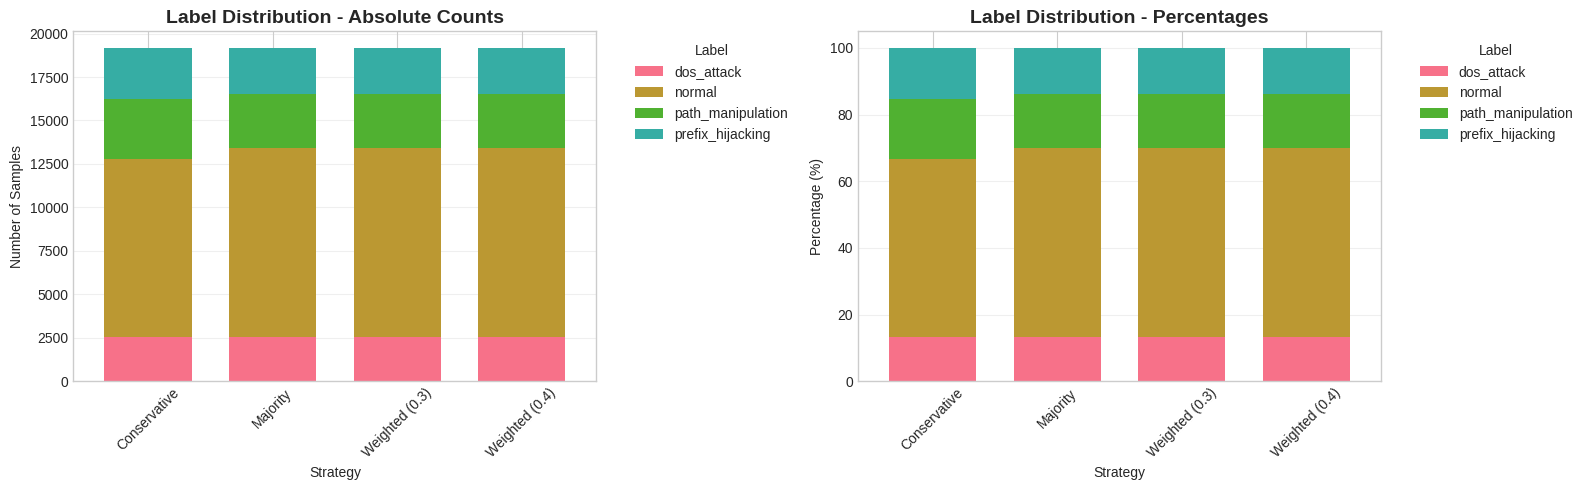

In [7]:
def analyze_label_distribution(datasets):
    """Analyze and visualize label distributions across strategies"""
    
    # Collect label counts
    label_data = []
    
    print("Label Distribution Analysis")
    print("=" * 80)
    
    for strategy, df in datasets.items():
        print(f"\n{strategy}:")
        label_counts = df['label'].value_counts()
        total = len(df)
        
        for label, count in label_counts.items():
            pct = (count / total) * 100
            print(f"  {label:25s}: {count:6,} ({pct:5.2f}%)")
            label_data.append({
                'Strategy': strategy,
                'Label': label,
                'Count': count,
                'Percentage': pct
            })
    
    # Create DataFrame for plotting
    label_df = pd.DataFrame(label_data)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Stacked bar chart (absolute counts)
    pivot_counts = label_df.pivot(index='Strategy', columns='Label', values='Count')
    pivot_counts.plot(kind='bar', stacked=True, ax=axes[0], width=0.7)
    axes[0].set_title('Label Distribution - Absolute Counts', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Strategy')
    axes[0].set_ylabel('Number of Samples')
    axes[0].legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Stacked bar chart (percentages)
    pivot_pct = label_df.pivot(index='Strategy', columns='Label', values='Percentage')
    pivot_pct.plot(kind='bar', stacked=True, ax=axes[1], width=0.7)
    axes[1].set_title('Label Distribution - Percentages', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Strategy')
    axes[1].set_ylabel('Percentage (%)')
    axes[1].legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'label_distribution.png'), bbox_inches='tight')
    plt.show()
    
    return label_df

label_df = analyze_label_distribution(datasets)

## 5. Inter-Strategy Agreement Analysis


Inter-Strategy Agreement Analysis

Conservative vs Majority:
  Cohen's Kappa: 0.9470
  Agreement:     96.66%

Conservative vs Weighted (0.3):
  Cohen's Kappa: 0.9475
  Agreement:     96.69%

Conservative vs Weighted (0.4):
  Cohen's Kappa: 0.9472
  Agreement:     96.68%

Majority vs Weighted (0.3):
  Cohen's Kappa: 0.9995
  Agreement:     99.97%

Majority vs Weighted (0.4):
  Cohen's Kappa: 0.9997
  Agreement:     99.98%

Weighted (0.3) vs Weighted (0.4):
  Cohen's Kappa: 0.9997
  Agreement:     99.98%


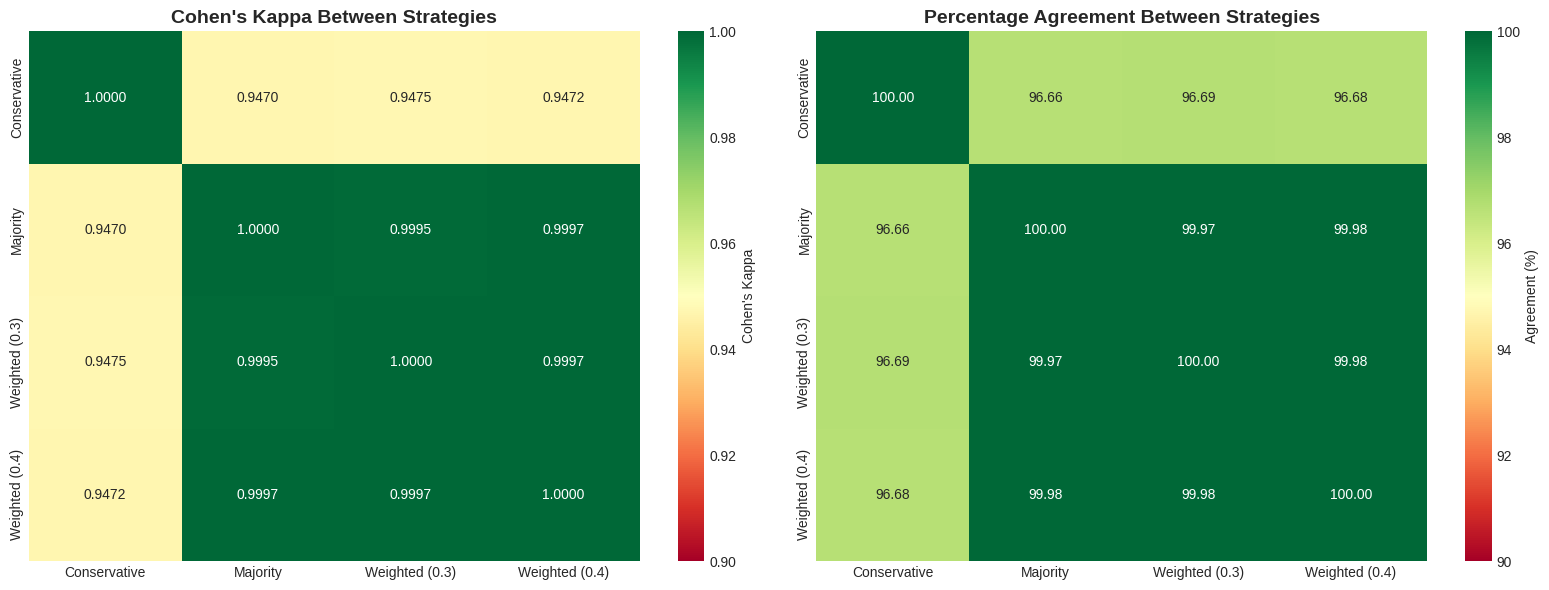

In [8]:
def calculate_agreement_matrix(datasets):
    """Calculate Cohen's Kappa between all strategy pairs"""
    
    strategies = list(datasets.keys())
    n_strategies = len(strategies)
    
    # Initialize matrices
    kappa_matrix = np.zeros((n_strategies, n_strategies))
    agreement_matrix = np.zeros((n_strategies, n_strategies))
    
    print("\nInter-Strategy Agreement Analysis")
    print("=" * 80)
    
    for i, strat1 in enumerate(strategies):
        for j, strat2 in enumerate(strategies):
            if i == j:
                kappa_matrix[i, j] = 1.0
                agreement_matrix[i, j] = 100.0
            elif i < j:
                labels1 = datasets[strat1]['label']
                labels2 = datasets[strat2]['label']
                
                # Calculate Cohen's Kappa
                kappa = cohen_kappa_score(labels1, labels2)
                kappa_matrix[i, j] = kappa
                kappa_matrix[j, i] = kappa
                
                # Calculate percentage agreement
                agreement = (labels1 == labels2).sum() / len(labels1) * 100
                agreement_matrix[i, j] = agreement
                agreement_matrix[j, i] = agreement
                
                print(f"\n{strat1} vs {strat2}:")
                print(f"  Cohen's Kappa: {kappa:.4f}")
                print(f"  Agreement:     {agreement:.2f}%")
    
    # Plot heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Cohen's Kappa heatmap
    sns.heatmap(kappa_matrix, annot=True, fmt='.4f', cmap='RdYlGn',
                xticklabels=strategies, yticklabels=strategies,
                vmin=0.9, vmax=1.0, ax=axes[0], cbar_kws={'label': "Cohen's Kappa"})
    axes[0].set_title("Cohen's Kappa Between Strategies", fontsize=14, fontweight='bold')
    
    # Agreement percentage heatmap
    sns.heatmap(agreement_matrix, annot=True, fmt='.2f', cmap='RdYlGn',
                xticklabels=strategies, yticklabels=strategies,
                vmin=90, vmax=100, ax=axes[1], cbar_kws={'label': 'Agreement (%)'})
    axes[1].set_title('Percentage Agreement Between Strategies', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'agreement_analysis.png'), bbox_inches='tight')
    plt.show()
    
    return kappa_matrix, agreement_matrix, strategies

kappa_matrix, agreement_matrix, strategies = calculate_agreement_matrix(datasets)

## 6. Disagreement Pattern Analysis

In [9]:
def analyze_disagreement_patterns(datasets):
    """Analyze patterns where strategies disagree"""
    
    # Create comparison dataframe
    comparison = pd.DataFrame({
        name: df['label'] for name, df in datasets.items()
    })
    
    # Find rows where not all strategies agree
    all_agree = comparison.apply(lambda row: len(set(row)) == 1, axis=1)
    disagreements = comparison[~all_agree]
    
    print("\nDisagreement Pattern Analysis")
    print("=" * 80)
    print(f"Total samples: {len(comparison):,}")
    print(f"Perfect agreement: {all_agree.sum():,} ({all_agree.sum()/len(comparison)*100:.2f}%)")
    print(f"Disagreements: {len(disagreements):,} ({len(disagreements)/len(comparison)*100:.2f}%)")
    
    if len(disagreements) > 0:
        print("\nTop 10 disagreement patterns:")
        patterns = disagreements.value_counts().head(10)
        
        for idx, (pattern, count) in enumerate(patterns.items(), 1):
            pct = (count / len(disagreements)) * 100
            pattern_str = ' | '.join([f"{col}:{val}" for col, val in zip(comparison.columns, pattern)])
            print(f"  {idx:2d}. {pattern_str}")
            print(f"      Count: {count:,} ({pct:.1f}% of disagreements)")
    
    return comparison, disagreements

comparison, disagreements = analyze_disagreement_patterns(datasets)


Disagreement Pattern Analysis
Total samples: 19,169
Perfect agreement: 18,529 (96.66%)
Disagreements: 640 (3.34%)

Top 10 disagreement patterns:
   1. Conservative:prefix_hijacking | Majority:normal | Weighted (0.3):normal | Weighted (0.4):normal
      Count: 326 (50.9% of disagreements)
   2. Conservative:path_manipulation | Majority:normal | Weighted (0.3):normal | Weighted (0.4):normal
      Count: 307 (48.0% of disagreements)
   3. Conservative:prefix_hijacking | Majority:normal | Weighted (0.3):prefix_hijacking | Weighted (0.4):normal
      Count: 3 (0.5% of disagreements)
   4. Conservative:path_manipulation | Majority:normal | Weighted (0.3):path_manipulation | Weighted (0.4):path_manipulation
      Count: 2 (0.3% of disagreements)
   5. Conservative:dos_attack | Majority:normal | Weighted (0.3):normal | Weighted (0.4):normal
      Count: 1 (0.2% of disagreements)
   6. Conservative:prefix_hijacking | Majority:normal | Weighted (0.3):prefix_hijacking | Weighted (0.4):prefix_hij

## 7. Machine Learning Performance Comparison

🔍 DIAGNOSING OPTUNA INTEGRATION ISSUE

1️⃣ Checking Optuna version...


[I 2025-11-25 14:15:36,795] A new study created in memory with name: no-name-f3ccde48-bc25-4326-af98-698ecf62ce81


   ✓ Optuna installed: 4.5.0
   ✓ optuna.integration exists

2️⃣ Checking XGBoost...
   ✓ XGBoost installed: 2.1.4

3️⃣ Checking LightGBM...
   ✓ LightGBM installed: 4.6.0

4️⃣ Checking Optuna integrations...
   ✓ XGBoostPruningCallback available
   ✓ LightGBMPruningCallback available

🔧 APPLYING FIX

✅ All integrations working!

📊 FINAL STATUS

📊 Final availability:
   Optuna:   True
   XGBoost:  True
   LightGBM: True

✅ ALL CHECKS PASSED!
   Optuna:   4.5.0
   XGBoost:  2.1.4
   LightGBM: 4.6.0

✓ You can now run the optimization with all 3 models!

⏱️  Starting CORRECTED Bayesian Optimization...
NO data leakage, ALL fixes applied!

🎯 CORRECTED BAYESIAN OPTIMIZATION (No Data Leakage!)
Split: 60% Train / 20% Val / 20% Test
HPO uses: Validation set only
Models: ['Random Forest', 'XGBoost', 'LightGBM']
Trials per model: 100

📊 Strategy: Conservative

📊 Data split:
   Train: 11,501 samples (60.0%)
   Val:   3,834 samples (20.0%)
   Test:  3,834 samples (20.0%)

  ───────────────────────

[I 2025-11-25 14:15:37,644] Trial 0 finished with value: 0.9960826034385063 and parameters: {'n_estimators': 218, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9960826034385063.
[I 2025-11-25 14:15:38,848] Trial 1 finished with value: 0.9830780750311832 and parameters: {'n_estimators': 369, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9960826034385063.
[I 2025-11-25 14:15:40,661] Trial 2 finished with value: 0.9986951698996622 and parameters: {'n_estimators': 244, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.9986951698996622.
[I 2025-11-25 14:15:42,721] Trial 3 finished with value: 0.9968675890647597 and parameters: {'n_estimators': 281, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_featur

  ✓ Best trial #10
  ✓ Best Validation F1 = 0.9992

  📋 Best hyperparameters:
     bootstrap                : False
     max_depth                : 29
     max_features             : None
     min_samples_leaf         : 1
     min_samples_split        : 8
     n_estimators             : 476

  🎓 Training final model on train+val...
  🔄 Cross-validation (with pipeline)...


[I 2025-11-25 14:21:10,907] A new study created in memory with name: no-name-2fc9c8bc-464f-4253-93ef-0aa529cdd13e



  📊 Final Test Performance:
     Accuracy:  0.9982
     Precision: 0.9982
     Recall:    0.9982
     F1:        0.9982
     CV Mean:   0.8938 ± 0.2104
     Time:      334.1s

  ────────────────────────────────────────────────────────────────────────────
  🤖 XGBoost
  ────────────────────────────────────────────────────────────────────────────
  🔬 Searching best hyperparameters...


[I 2025-11-25 14:21:12,188] Trial 0 finished with value: 0.9955586325226389 and parameters: {'n_estimators': 218, 'max_depth': 20, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.9955586325226389.
[I 2025-11-25 14:21:13,908] Trial 1 finished with value: 0.9955584317693124 and parameters: {'n_estimators': 369, 'max_depth': 2, 'learning_rate': 0.2526878207508456, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.9955586325226389.
[I 2025-11-25 14:21:15,297] Trial 2 finished with value: 0.9952948358633985 and parameters: {'n_estimators': 244, 'max_depth': 7, 'learning_rate': 0.032781876533976156, 'subsample': 0.5

  ✓ Best trial #32
  ✓ Best Validation F1 = 0.9974

  📋 Best hyperparameters:
     colsample_bytree         : 0.7134453207884411
     gamma                    : 1.0955216882360066
     learning_rate            : 0.09605532040478057
     max_depth                : 14
     min_child_weight         : 7
     n_estimators             : 199
     reg_alpha                : 0.6253262345257808
     reg_lambda               : 0.06551857724149418
     subsample                : 0.7600704060619028

  🎓 Training final model on train+val...
  🔄 Cross-validation (with pipeline)...


/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:23:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:23:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:23:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:23:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/sm


  📊 Final Test Performance:
     Accuracy:  0.9966
     Precision: 0.9966
     Recall:    0.9966
     F1:        0.9966
     CV Mean:   0.9977 ± 0.0008
     Time:      134.9s

  ────────────────────────────────────────────────────────────────────────────
  🤖 LightGBM
  ────────────────────────────────────────────────────────────────────────────
  🔬 Searching best hyperparameters...


[I 2025-11-25 14:23:26,632] Trial 0 finished with value: 0.9960813168697192 and parameters: {'n_estimators': 218, 'max_depth': 20, 'learning_rate': 0.06504856968981275, 'num_leaves': 128, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'min_child_samples': 7, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.9960813168697192.
[I 2025-11-25 14:23:27,764] Trial 1 finished with value: 0.9976495467624595 and parameters: {'n_estimators': 369, 'max_depth': 2, 'learning_rate': 0.2526878207508456, 'num_leaves': 170, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'min_child_samples': 13, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 1 with value: 0.9976495467624595.
[I 2025-11-25 14:23:28,899] Trial 2 finished with value: 0.9952969859337678 and parameters: {'n_estimators': 244, 'max_depth': 7, 'learning_rate': 0.032781876533976156, 'num_leaves': 45, 'subsample': 0.

  ✓ Best trial #27
  ✓ Best Validation F1 = 0.9990

  📋 Best hyperparameters:
     colsample_bytree         : 0.7854306298220278
     learning_rate            : 0.16796129973404408
     max_depth                : 11
     min_child_samples        : 35
     n_estimators             : 392
     num_leaves               : 115
     reg_alpha                : 0.034563295596162336
     reg_lambda               : 1.0287121039661802
     subsample                : 0.9240487997744222

  🎓 Training final model on train+val...
  🔄 Cross-validation (with pipeline)...


[I 2025-11-25 14:42:16,767] A new study created in memory with name: no-name-34104b22-a1f9-4499-81e2-51307da13967



  📊 Final Test Performance:
     Accuracy:  0.9979
     Precision: 0.9979
     Recall:    0.9979
     F1:        0.9979
     CV Mean:   0.8956 ± 0.2065
     Time:      1130.9s

📊 Strategy: Majority

📊 Data split:
   Train: 11,501 samples (60.0%)
   Val:   3,834 samples (20.0%)
   Test:  3,834 samples (20.0%)

  ────────────────────────────────────────────────────────────────────────────
  🤖 Random Forest
  ────────────────────────────────────────────────────────────────────────────
  🔬 Searching best hyperparameters...


[I 2025-11-25 14:42:17,545] Trial 0 finished with value: 0.999217770950519 and parameters: {'n_estimators': 218, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.999217770950519.
[I 2025-11-25 14:42:18,708] Trial 1 finished with value: 0.9798025427093946 and parameters: {'n_estimators': 369, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.999217770950519.
[I 2025-11-25 14:42:20,416] Trial 2 finished with value: 0.999217770950519 and parameters: {'n_estimators': 244, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.999217770950519.
[I 2025-11-25 14:42:22,366] Trial 3 finished with value: 0.9984350000628555 and parameters: {'n_estimators': 281, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 

  ✓ Best trial #80
  ✓ Best Validation F1 = 0.9997

  📋 Best hyperparameters:
     bootstrap                : False
     max_depth                : 47
     max_features             : log2
     min_samples_leaf         : 1
     min_samples_split        : 12
     n_estimators             : 495

  🎓 Training final model on train+val...
  🔄 Cross-validation (with pipeline)...


[I 2025-11-25 14:44:37,640] A new study created in memory with name: no-name-41ff598a-f072-4b63-801f-3af534e2dd7e



  📊 Final Test Performance:
     Accuracy:  0.9992
     Precision: 0.9992
     Recall:    0.9992
     F1:        0.9992
     CV Mean:   0.9990 ± 0.0005
     Time:      140.8s

  ────────────────────────────────────────────────────────────────────────────
  🤖 XGBoost
  ────────────────────────────────────────────────────────────────────────────
  🔬 Searching best hyperparameters...


[I 2025-11-25 14:44:38,970] Trial 0 finished with value: 0.9955613998456522 and parameters: {'n_estimators': 218, 'max_depth': 20, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.9955613998456522.
[I 2025-11-25 14:44:40,686] Trial 1 finished with value: 0.9958228773439335 and parameters: {'n_estimators': 369, 'max_depth': 2, 'learning_rate': 0.2526878207508456, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 1 with value: 0.9958228773439335.
[I 2025-11-25 14:44:42,103] Trial 2 finished with value: 0.995560971543545 and parameters: {'n_estimators': 244, 'max_depth': 7, 'learning_rate': 0.032781876533976156, 'subsample': 0.56

  ✓ Best trial #25
  ✓ Best Validation F1 = 0.9992

  📋 Best hyperparameters:
     colsample_bytree         : 0.799504495187019
     gamma                    : 0.0018467070566488553
     learning_rate            : 0.036303424778608054
     max_depth                : 13
     min_child_weight         : 2
     n_estimators             : 289
     reg_alpha                : 3.696403503594854
     reg_lambda               : 5.419227925954777
     subsample                : 0.6858875001595252

  🎓 Training final model on train+val...
  🔄 Cross-validation (with pipeline)...


/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:46:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:46:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:46:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:46:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/sm


  📊 Final Test Performance:
     Accuracy:  0.9992
     Precision: 0.9992
     Recall:    0.9992
     F1:        0.9992
     CV Mean:   0.9983 ± 0.0009
     Time:      141.6s

  ────────────────────────────────────────────────────────────────────────────
  🤖 LightGBM
  ────────────────────────────────────────────────────────────────────────────
  🔬 Searching best hyperparameters...


[I 2025-11-25 14:47:00,088] Trial 0 finished with value: 0.9958228773439335 and parameters: {'n_estimators': 218, 'max_depth': 20, 'learning_rate': 0.06504856968981275, 'num_leaves': 128, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'min_child_samples': 7, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.9958228773439335.
[I 2025-11-25 14:47:01,258] Trial 1 finished with value: 0.9981735609336612 and parameters: {'n_estimators': 369, 'max_depth': 2, 'learning_rate': 0.2526878207508456, 'num_leaves': 170, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'min_child_samples': 13, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 1 with value: 0.9981735609336612.
[I 2025-11-25 14:47:02,290] Trial 2 finished with value: 0.9963459394396619 and parameters: {'n_estimators': 244, 'max_depth': 7, 'learning_rate': 0.032781876533976156, 'num_leaves': 45, 'subsample': 0.

  ✓ Best trial #44
  ✓ Best Validation F1 = 1.0000

  📋 Best hyperparameters:
     colsample_bytree         : 0.5983964783610372
     learning_rate            : 0.15123614909783578
     max_depth                : 12
     min_child_samples        : 44
     n_estimators             : 397
     num_leaves               : 95
     reg_alpha                : 0.033313171635580535
     reg_lambda               : 9.557828093986643
     subsample                : 0.9627705236217159

  🎓 Training final model on train+val...
  🔄 Cross-validation (with pipeline)...


[I 2025-11-25 15:07:29,496] A new study created in memory with name: no-name-b0e65153-3137-4b52-8d5d-f8641712d8ea



  📊 Final Test Performance:
     Accuracy:  0.9992
     Precision: 0.9992
     Recall:    0.9992
     F1:        0.9992
     CV Mean:   0.9993 ± 0.0002
     Time:      1230.2s

📊 Strategy: Weighted (0.3)

📊 Data split:
   Train: 11,501 samples (60.0%)
   Val:   3,834 samples (20.0%)
   Test:  3,834 samples (20.0%)

  ────────────────────────────────────────────────────────────────────────────
  🤖 Random Forest
  ────────────────────────────────────────────────────────────────────────────
  🔬 Searching best hyperparameters...


[I 2025-11-25 15:07:30,298] Trial 0 finished with value: 0.9989552865399379 and parameters: {'n_estimators': 218, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9989552865399379.
[I 2025-11-25 15:07:31,472] Trial 1 finished with value: 0.9805628927498488 and parameters: {'n_estimators': 369, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9989552865399379.
[I 2025-11-25 15:07:33,206] Trial 2 finished with value: 0.9989558672962987 and parameters: {'n_estimators': 244, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.9989558672962987.
[I 2025-11-25 15:07:35,227] Trial 3 finished with value: 0.9981723457688125 and parameters: {'n_estimators': 281, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_featur

  ✓ Best trial #20
  ✓ Best Validation F1 = 0.9995

  📋 Best hyperparameters:
     bootstrap                : False
     max_depth                : 39
     max_features             : log2
     min_samples_leaf         : 1
     min_samples_split        : 10
     n_estimators             : 286

  🎓 Training final model on train+val...
  🔄 Cross-validation (with pipeline)...


[I 2025-11-25 15:09:36,202] A new study created in memory with name: no-name-dc2d5c88-f178-4871-95bf-cb35cd6cae4a



  📊 Final Test Performance:
     Accuracy:  0.9990
     Precision: 0.9990
     Recall:    0.9990
     F1:        0.9990
     CV Mean:   0.9989 ± 0.0006
     Time:      126.7s

  ────────────────────────────────────────────────────────────────────────────
  🤖 XGBoost
  ────────────────────────────────────────────────────────────────────────────
  🔬 Searching best hyperparameters...


[I 2025-11-25 15:09:37,519] Trial 0 finished with value: 0.9968635419056617 and parameters: {'n_estimators': 218, 'max_depth': 20, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.9968635419056617.
[I 2025-11-25 15:09:39,244] Trial 1 finished with value: 0.9968625603829605 and parameters: {'n_estimators': 369, 'max_depth': 2, 'learning_rate': 0.2526878207508456, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.9968635419056617.
[I 2025-11-25 15:09:40,607] Trial 2 finished with value: 0.996079767778739 and parameters: {'n_estimators': 244, 'max_depth': 7, 'learning_rate': 0.032781876533976156, 'subsample': 0.56

  ✓ Best trial #12
  ✓ Best Validation F1 = 0.9995

  📋 Best hyperparameters:
     colsample_bytree         : 0.8045369317168723
     gamma                    : 0.23620487631194897
     learning_rate            : 0.09040514921116717
     max_depth                : 17
     min_child_weight         : 3
     n_estimators             : 55
     reg_alpha                : 0.33585884934472077
     reg_lambda               : 6.826926211335165
     subsample                : 0.8605213354247512

  🎓 Training final model on train+val...
  🔄 Cross-validation (with pipeline)...


/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:11:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:11:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:11:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:11:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/sm


  📊 Final Test Performance:
     Accuracy:  0.9984
     Precision: 0.9984
     Recall:    0.9984
     F1:        0.9984
     CV Mean:   0.9982 ± 0.0008
     Time:      112.6s

  ────────────────────────────────────────────────────────────────────────────
  🤖 LightGBM
  ────────────────────────────────────────────────────────────────────────────
  🔬 Searching best hyperparameters...


[I 2025-11-25 15:11:29,638] Trial 0 finished with value: 0.9968625603829605 and parameters: {'n_estimators': 218, 'max_depth': 20, 'learning_rate': 0.06504856968981275, 'num_leaves': 128, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'min_child_samples': 7, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.9968625603829605.
[I 2025-11-25 15:11:30,840] Trial 1 finished with value: 0.9968625603829605 and parameters: {'n_estimators': 369, 'max_depth': 2, 'learning_rate': 0.2526878207508456, 'num_leaves': 170, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'min_child_samples': 13, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.9968625603829605.
[I 2025-11-25 15:11:31,921] Trial 2 finished with value: 0.9968625603829605 and parameters: {'n_estimators': 244, 'max_depth': 7, 'learning_rate': 0.032781876533976156, 'num_leaves': 45, 'subsample': 0.

  ✓ Best trial #13
  ✓ Best Validation F1 = 0.9997

  📋 Best hyperparameters:
     colsample_bytree         : 0.5859890951691943
     learning_rate            : 0.1044905949268345
     max_depth                : 11
     min_child_samples        : 13
     n_estimators             : 426
     num_leaves               : 159
     reg_alpha                : 1.7057827940885526
     reg_lambda               : 6.855046081289342
     subsample                : 0.5027261947767732

  🎓 Training final model on train+val...
  🔄 Cross-validation (with pipeline)...


[I 2025-11-25 15:23:38,764] A new study created in memory with name: no-name-a5cbab07-6221-40af-b028-acd560a060fd



  📊 Final Test Performance:
     Accuracy:  0.9987
     Precision: 0.9987
     Recall:    0.9987
     F1:        0.9987
     CV Mean:   0.9985 ± 0.0007
     Time:      729.9s

📊 Strategy: Weighted (0.4)

📊 Data split:
   Train: 11,501 samples (60.0%)
   Val:   3,834 samples (20.0%)
   Test:  3,834 samples (20.0%)

  ────────────────────────────────────────────────────────────────────────────
  🤖 Random Forest
  ────────────────────────────────────────────────────────────────────────────
  🔬 Searching best hyperparameters...


[I 2025-11-25 15:23:39,558] Trial 0 finished with value: 0.9989568879404364 and parameters: {'n_estimators': 218, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9989568879404364.
[I 2025-11-25 15:23:40,730] Trial 1 finished with value: 0.9828421547934517 and parameters: {'n_estimators': 369, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9989568879404364.
[I 2025-11-25 15:23:42,406] Trial 2 finished with value: 0.9997391716631908 and parameters: {'n_estimators': 244, 'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.9997391716631908.
[I 2025-11-25 15:23:44,327] Trial 3 finished with value: 0.9984345381065594 and parameters: {'n_estimators': 281, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_featur

  ✓ Best trial #6
  ✓ Best Validation F1 = 1.0000

  📋 Best hyperparameters:
     bootstrap                : False
     max_depth                : 47
     max_features             : None
     min_samples_leaf         : 2
     min_samples_split        : 3
     n_estimators             : 319

  🎓 Training final model on train+val...
  🔄 Cross-validation (with pipeline)...


[I 2025-11-25 15:27:46,899] A new study created in memory with name: no-name-e97df834-bfea-430e-a826-daaf8bb06ecc



  📊 Final Test Performance:
     Accuracy:  0.9995
     Precision: 0.9995
     Recall:    0.9995
     F1:        0.9995
     CV Mean:   0.9990 ± 0.0006
     Time:      248.1s

  ────────────────────────────────────────────────────────────────────────────
  🤖 XGBoost
  ────────────────────────────────────────────────────────────────────────────
  🔬 Searching best hyperparameters...


[I 2025-11-25 15:27:48,177] Trial 0 finished with value: 0.9963455635045918 and parameters: {'n_estimators': 218, 'max_depth': 20, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.9963455635045918.
[I 2025-11-25 15:27:49,893] Trial 1 finished with value: 0.9963455635045918 and parameters: {'n_estimators': 369, 'max_depth': 2, 'learning_rate': 0.2526878207508456, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.9963455635045918.
[I 2025-11-25 15:27:51,298] Trial 2 finished with value: 0.9966060818912313 and parameters: {'n_estimators': 244, 'max_depth': 7, 'learning_rate': 0.032781876533976156, 'subsample': 0.5

  ✓ Best trial #77
  ✓ Best Validation F1 = 1.0000

  📋 Best hyperparameters:
     colsample_bytree         : 0.6943749463041802
     gamma                    : 0.4418092696331424
     learning_rate            : 0.19992718680461738
     max_depth                : 2
     min_child_weight         : 7
     n_estimators             : 237
     reg_alpha                : 0.3196597336891758
     reg_lambda               : 0.32394468716463576
     subsample                : 0.6637194770247423

  🎓 Training final model on train+val...
  🔄 Cross-validation (with pipeline)...


/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:30:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:30:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:30:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/smotaali/BGP_Traffic_Generation/generator/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:30:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/sm


  📊 Final Test Performance:
     Accuracy:  0.9990
     Precision: 0.9990
     Recall:    0.9990
     F1:        0.9990
     CV Mean:   0.9983 ± 0.0008
     Time:      148.9s

  ────────────────────────────────────────────────────────────────────────────
  🤖 LightGBM
  ────────────────────────────────────────────────────────────────────────────
  🔬 Searching best hyperparameters...


[I 2025-11-25 15:30:16,637] Trial 0 finished with value: 0.9973902533973952 and parameters: {'n_estimators': 218, 'max_depth': 20, 'learning_rate': 0.06504856968981275, 'num_leaves': 128, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'min_child_samples': 7, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.9973902533973952.
[I 2025-11-25 15:30:17,833] Trial 1 finished with value: 0.9992174710471642 and parameters: {'n_estimators': 369, 'max_depth': 2, 'learning_rate': 0.2526878207508456, 'num_leaves': 170, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'min_child_samples': 13, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 1 with value: 0.9992174710471642.
[I 2025-11-25 15:30:18,892] Trial 2 finished with value: 0.9968674991050023 and parameters: {'n_estimators': 244, 'max_depth': 7, 'learning_rate': 0.032781876533976156, 'num_leaves': 45, 'subsample': 0.

  ✓ Best trial #27
  ✓ Best Validation F1 = 0.9997

  📋 Best hyperparameters:
     colsample_bytree         : 0.7962639675102624
     learning_rate            : 0.17058703852930385
     max_depth                : 2
     min_child_samples        : 44
     n_estimators             : 449
     num_leaves               : 54
     reg_alpha                : 1.9471244908442498
     reg_lambda               : 7.607428634722769
     subsample                : 0.9261577639623139

  🎓 Training final model on train+val...
  🔄 Cross-validation (with pipeline)...

  📊 Final Test Performance:
     Accuracy:  0.9990
     Precision: 0.9990
     Recall:    0.9990
     F1:        0.9990
     CV Mean:   0.9980 ± 0.0009
     Time:      445.0s

✅ Optimization Completed - Clean, Safe, Correct!

📊 RESULTS


,Strategy,Model,Test_F1,Val_F1,CV_Mean,CV_Std
0,Conservative,Random Forest,0.9982,0.9992,0.8938,0.2104
1,Conservative,XGBoost,0.9966,0.9974,0.9977,0.0008
2,Conservative,LightGBM,0.9979,0.9990,0.8956,0.2065
3,Majority,Random Forest,0.9992,0.9997,0.9990,0.0005
4,Majority,XGBoost,0.9992,0.9992,0.9983,0.0009
5,Majority,LightGBM,0.9992,1.0000,0.9993,0.0002
6,Weighted (0.3),Random Forest,0.9990,0.9995,0.9989,0.0006
7,Weighted (0.3),XGBoost,0.9984,0.9995,0.9982,0.0008
8,Weighted (0.3),LightGBM,0.9987,0.9997,0.9985,0.0007
9,Weighted (0.4),Random Forest,0.9995,1.0000,0.9990,0.0006



✓ Saved: /home/smotaali/BGP_Traffic_Generation/results/final_corrected_results.csv

📈 Creating Visualizations

📊 Creating Optimization Visualizations...
--------------------------------------------------------------------------------


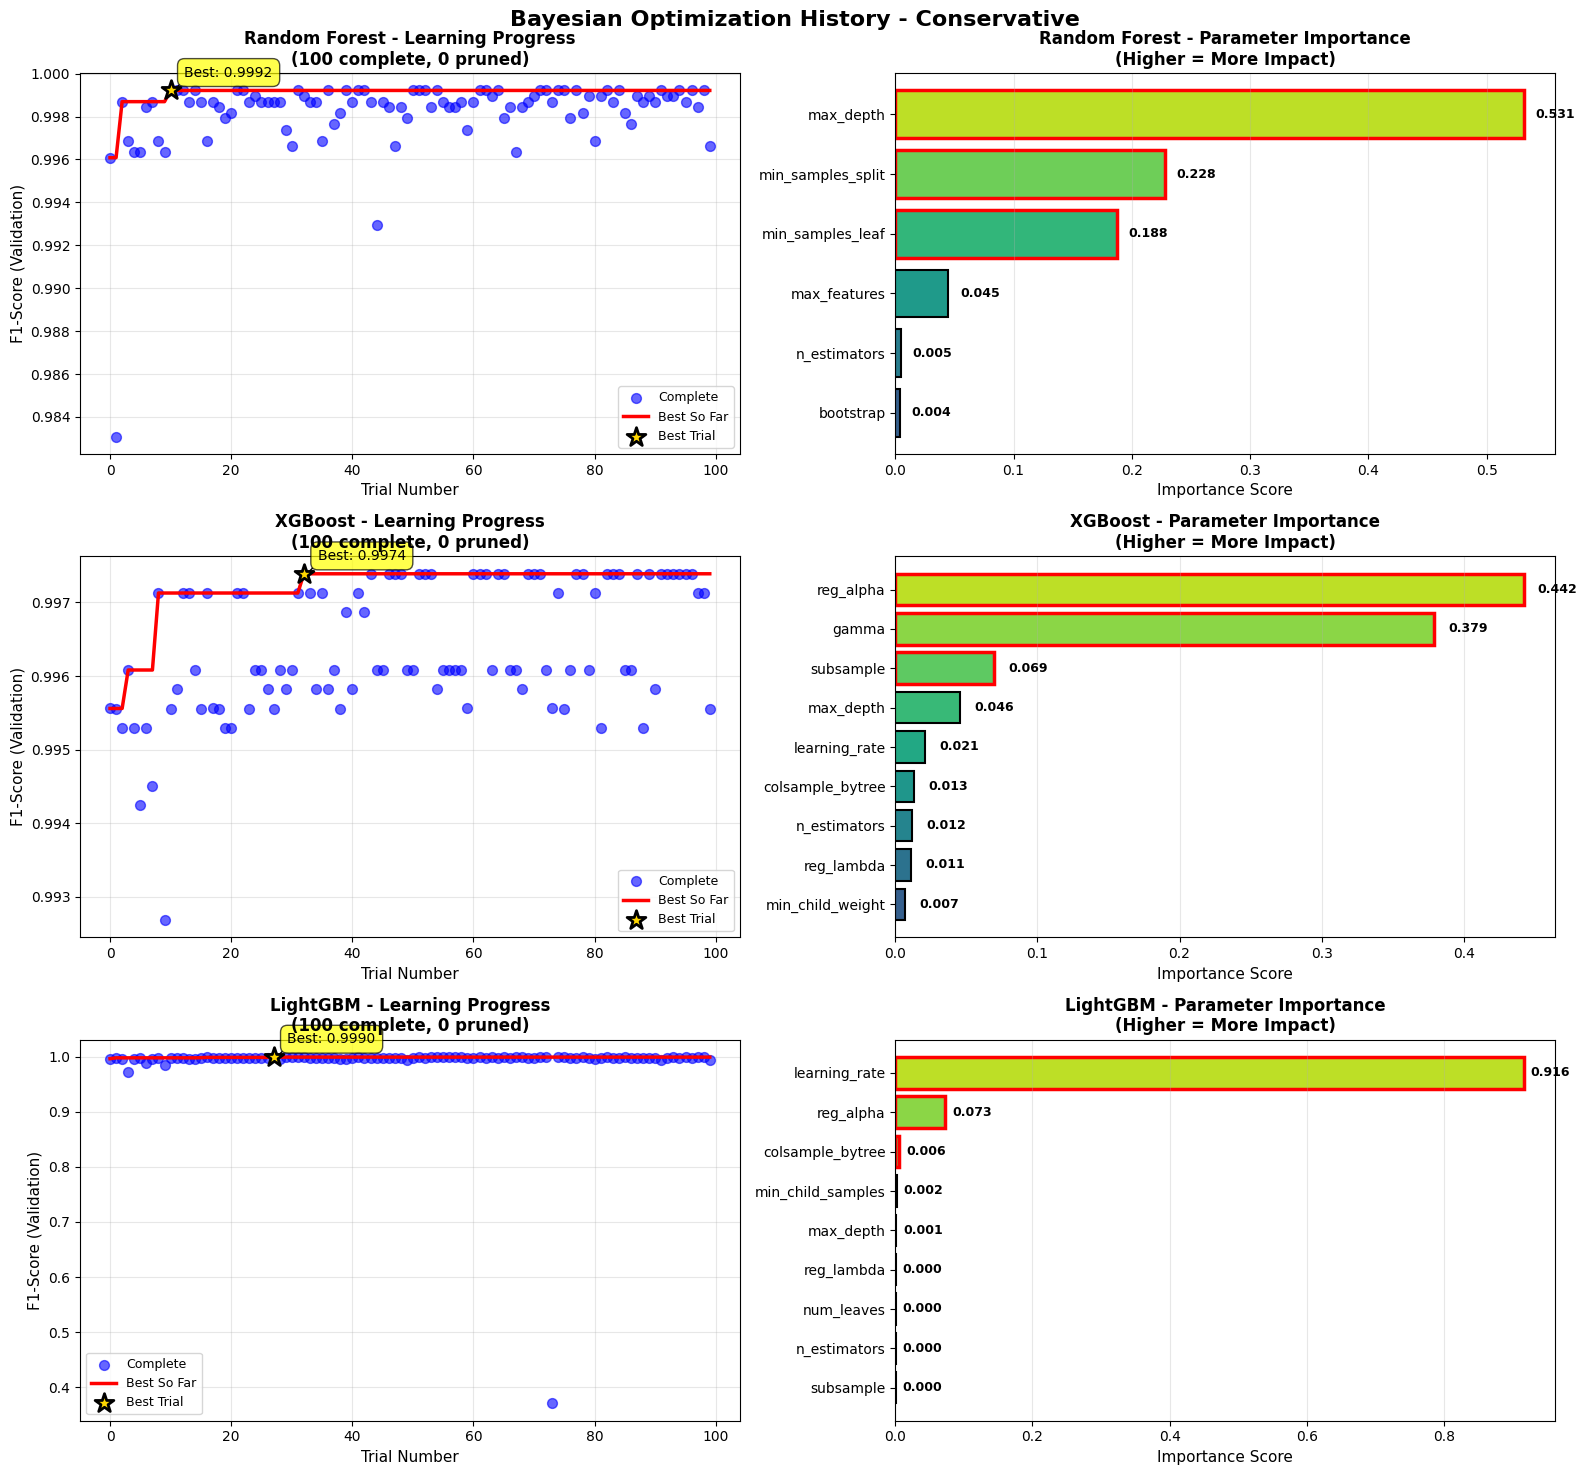

  ✓ Saved: optuna_history_conservative.png


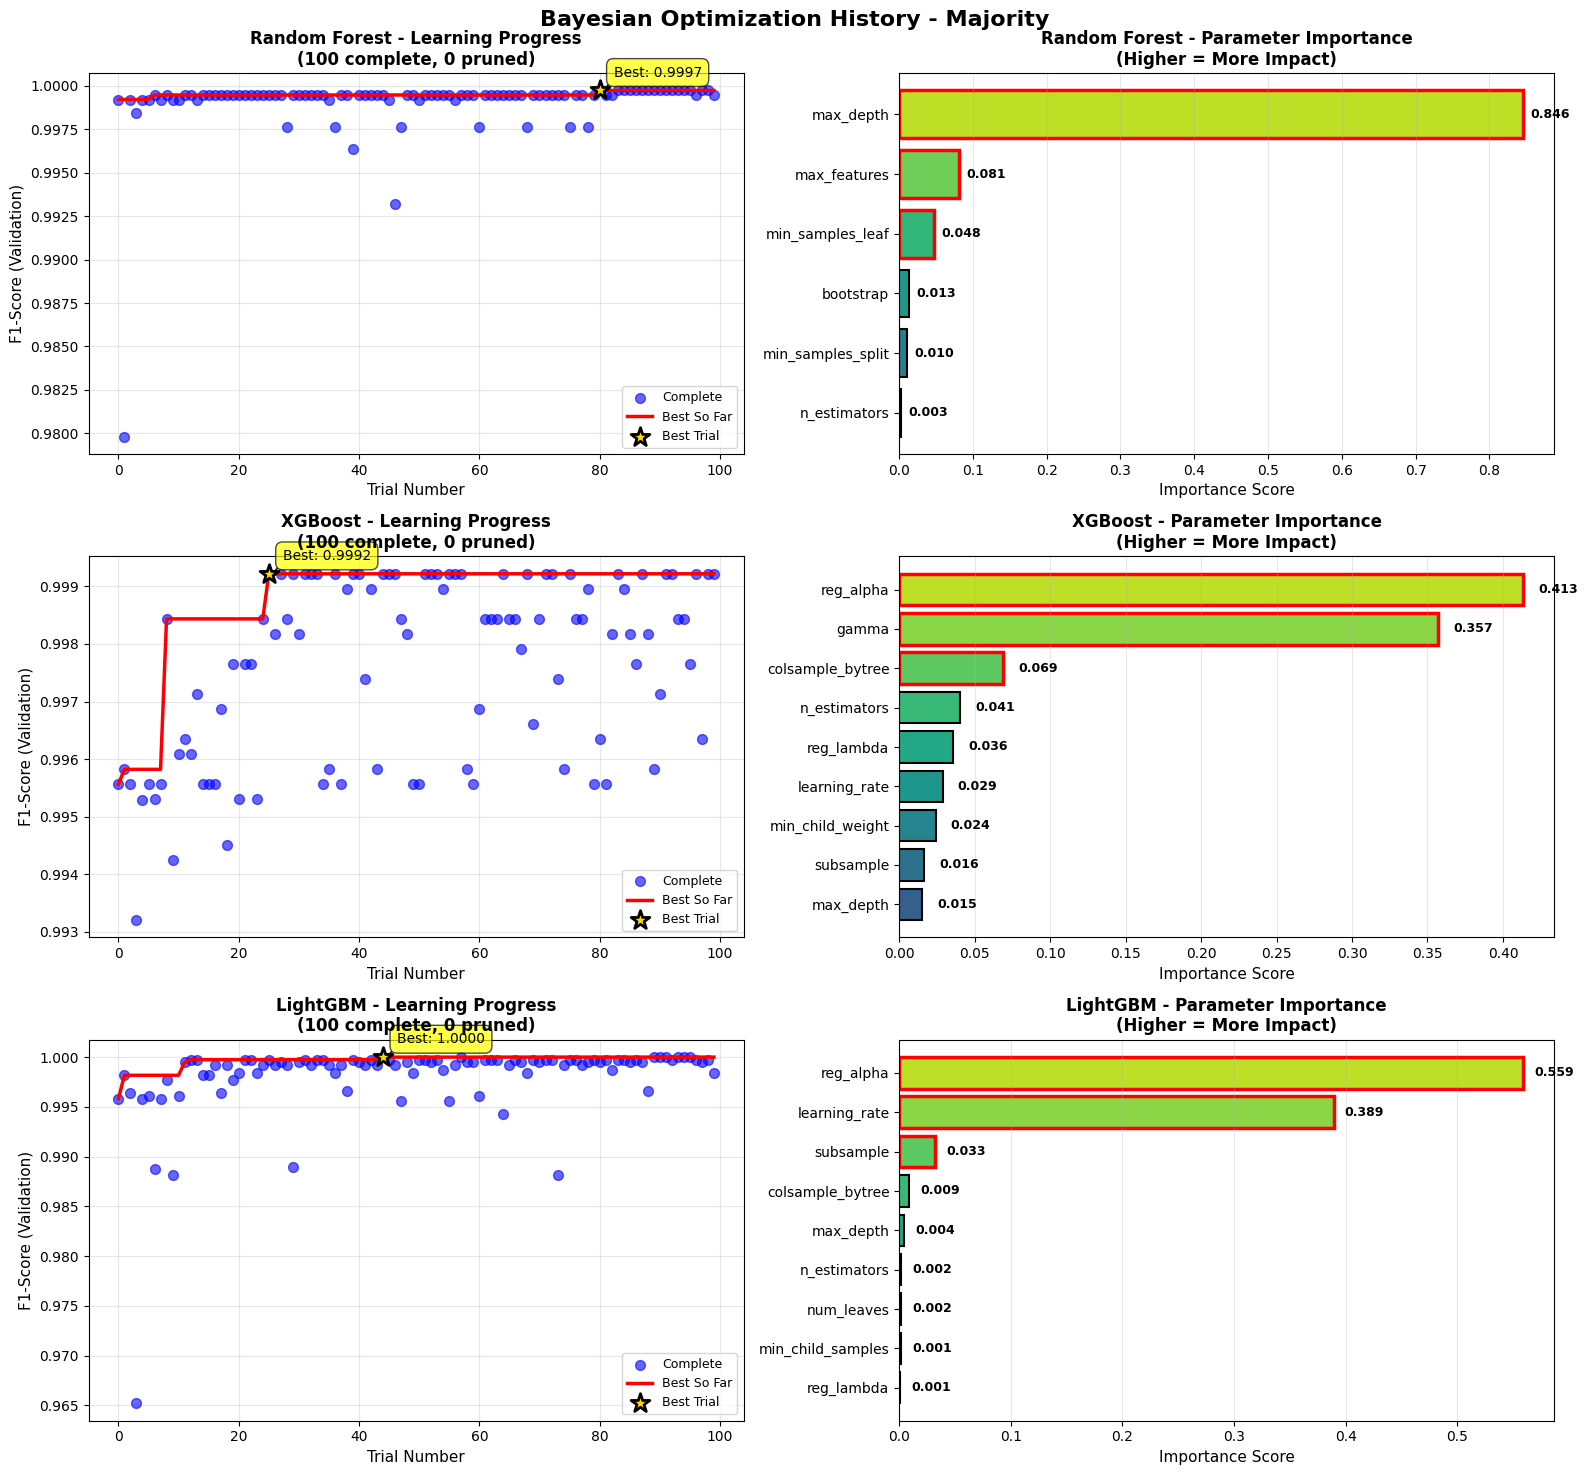

  ✓ Saved: optuna_history_majority.png


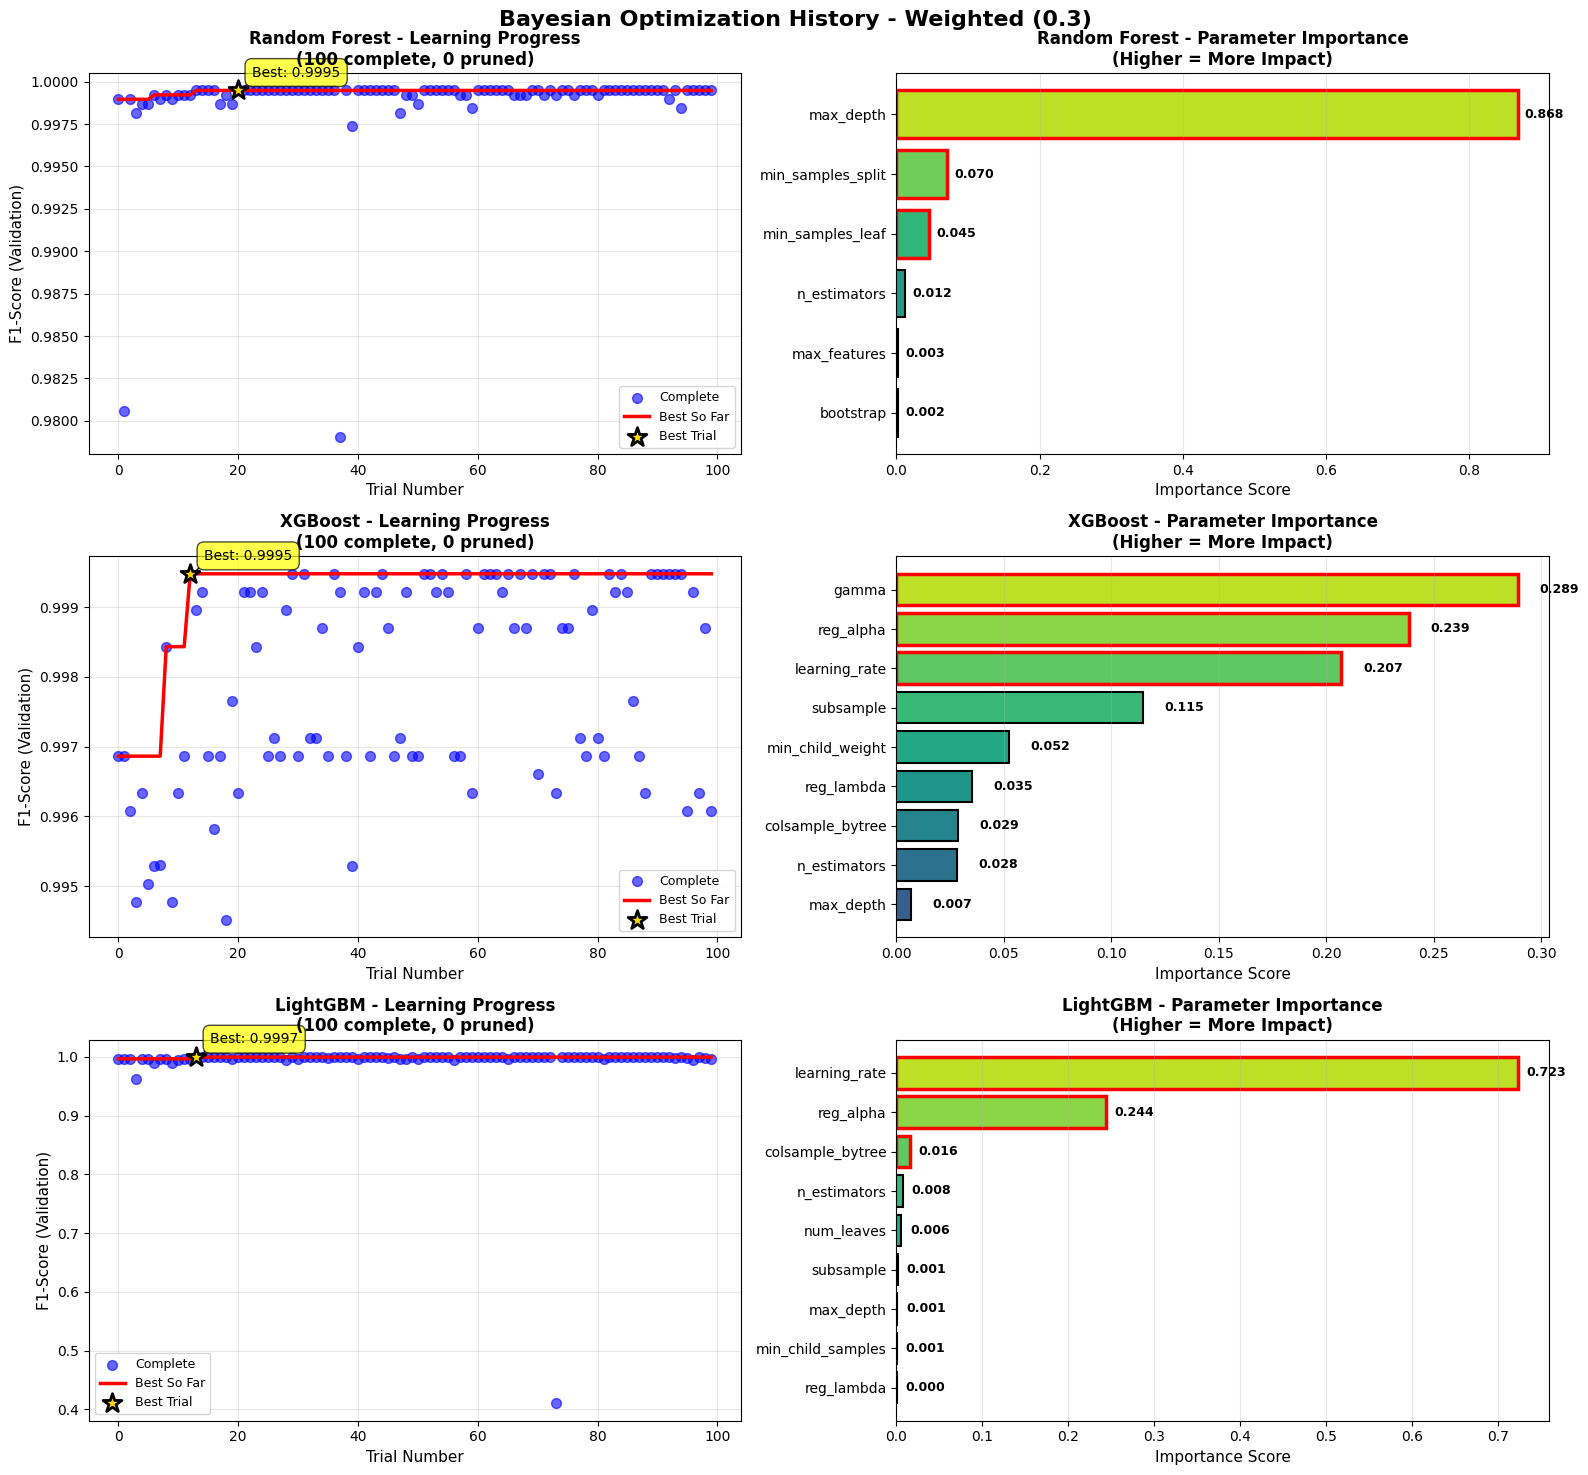

  ✓ Saved: optuna_history_weighted_0.3.png


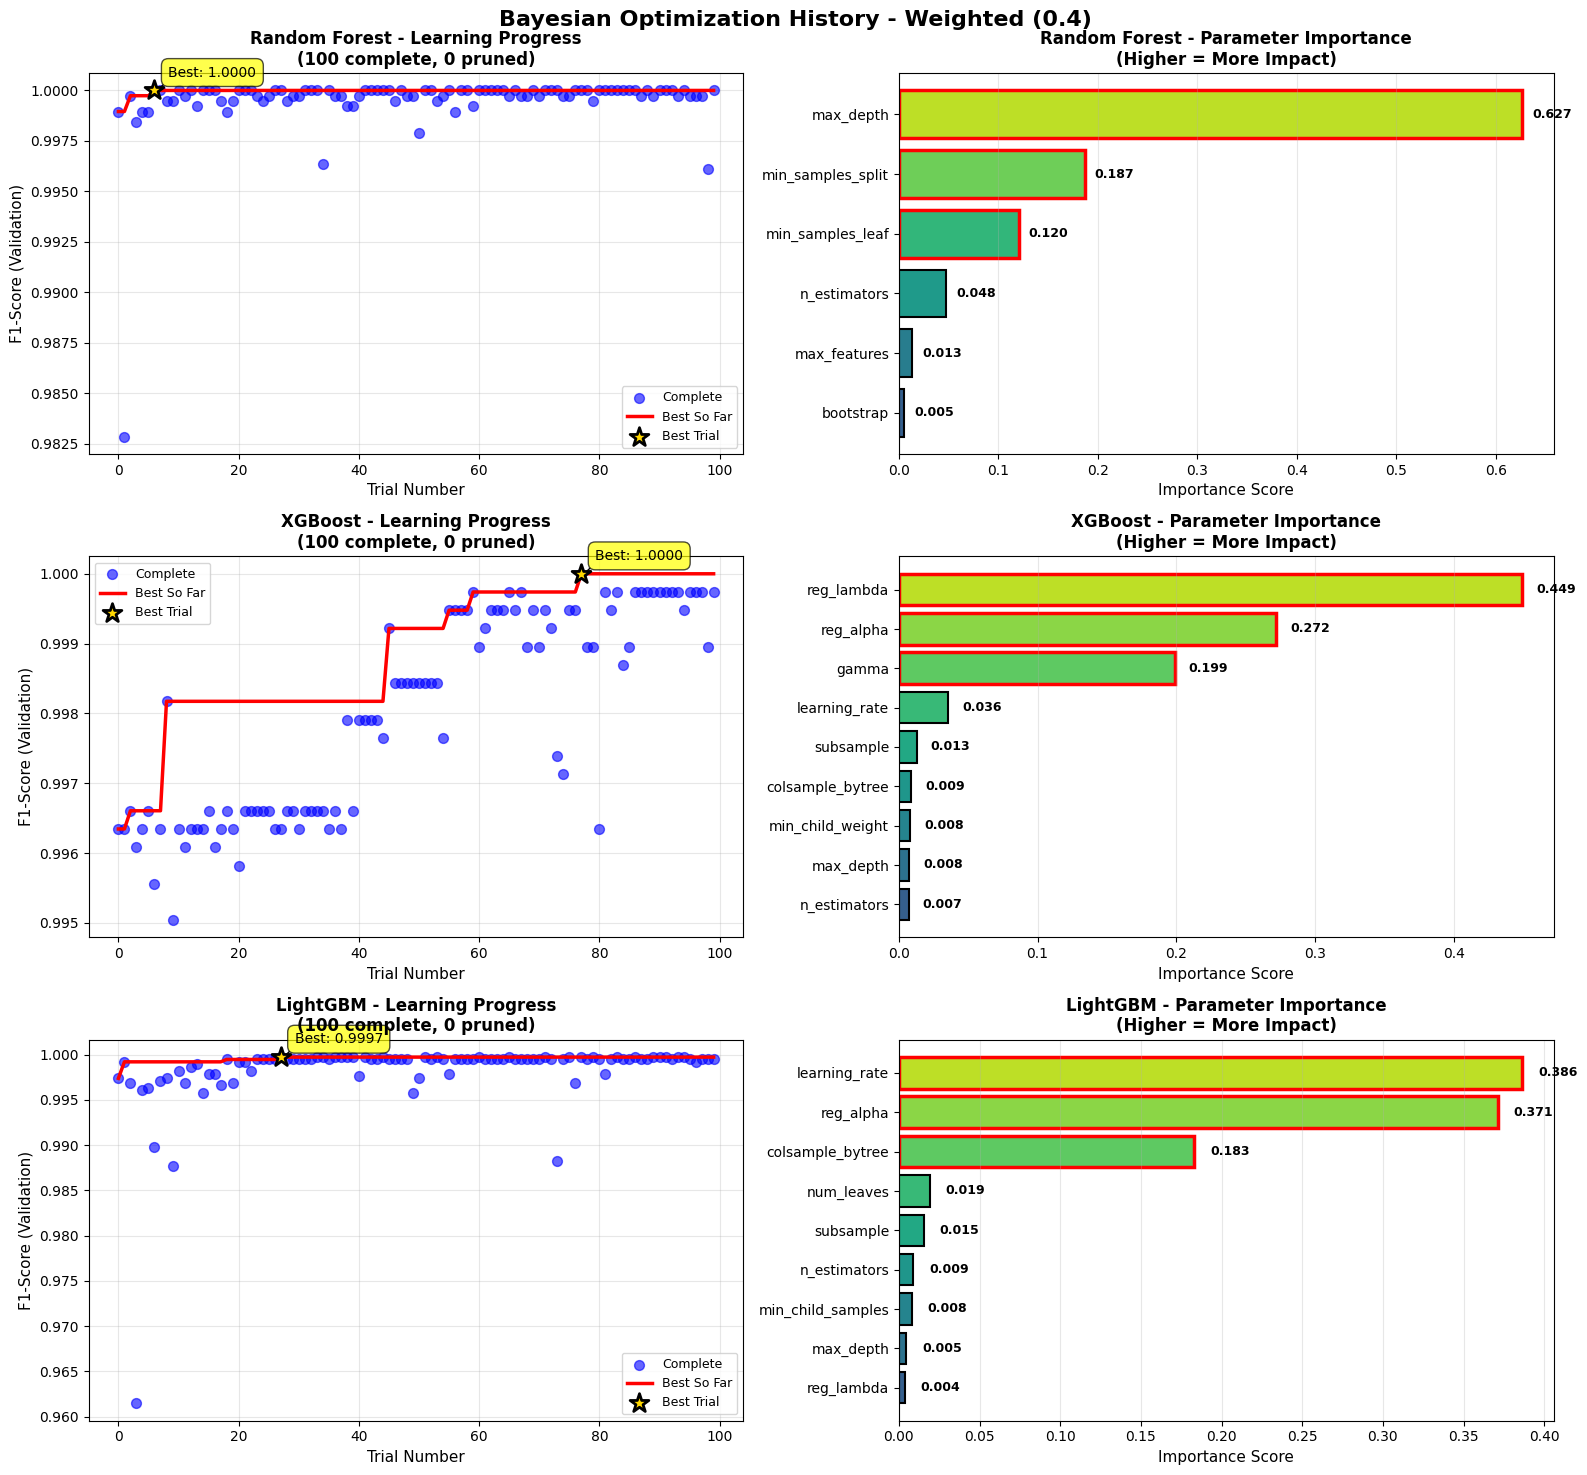

  ✓ Saved: optuna_history_weighted_0.4.png

✅ Optimization visualizations completed!

📊 Creating Performance Comparison...
--------------------------------------------------------------------------------


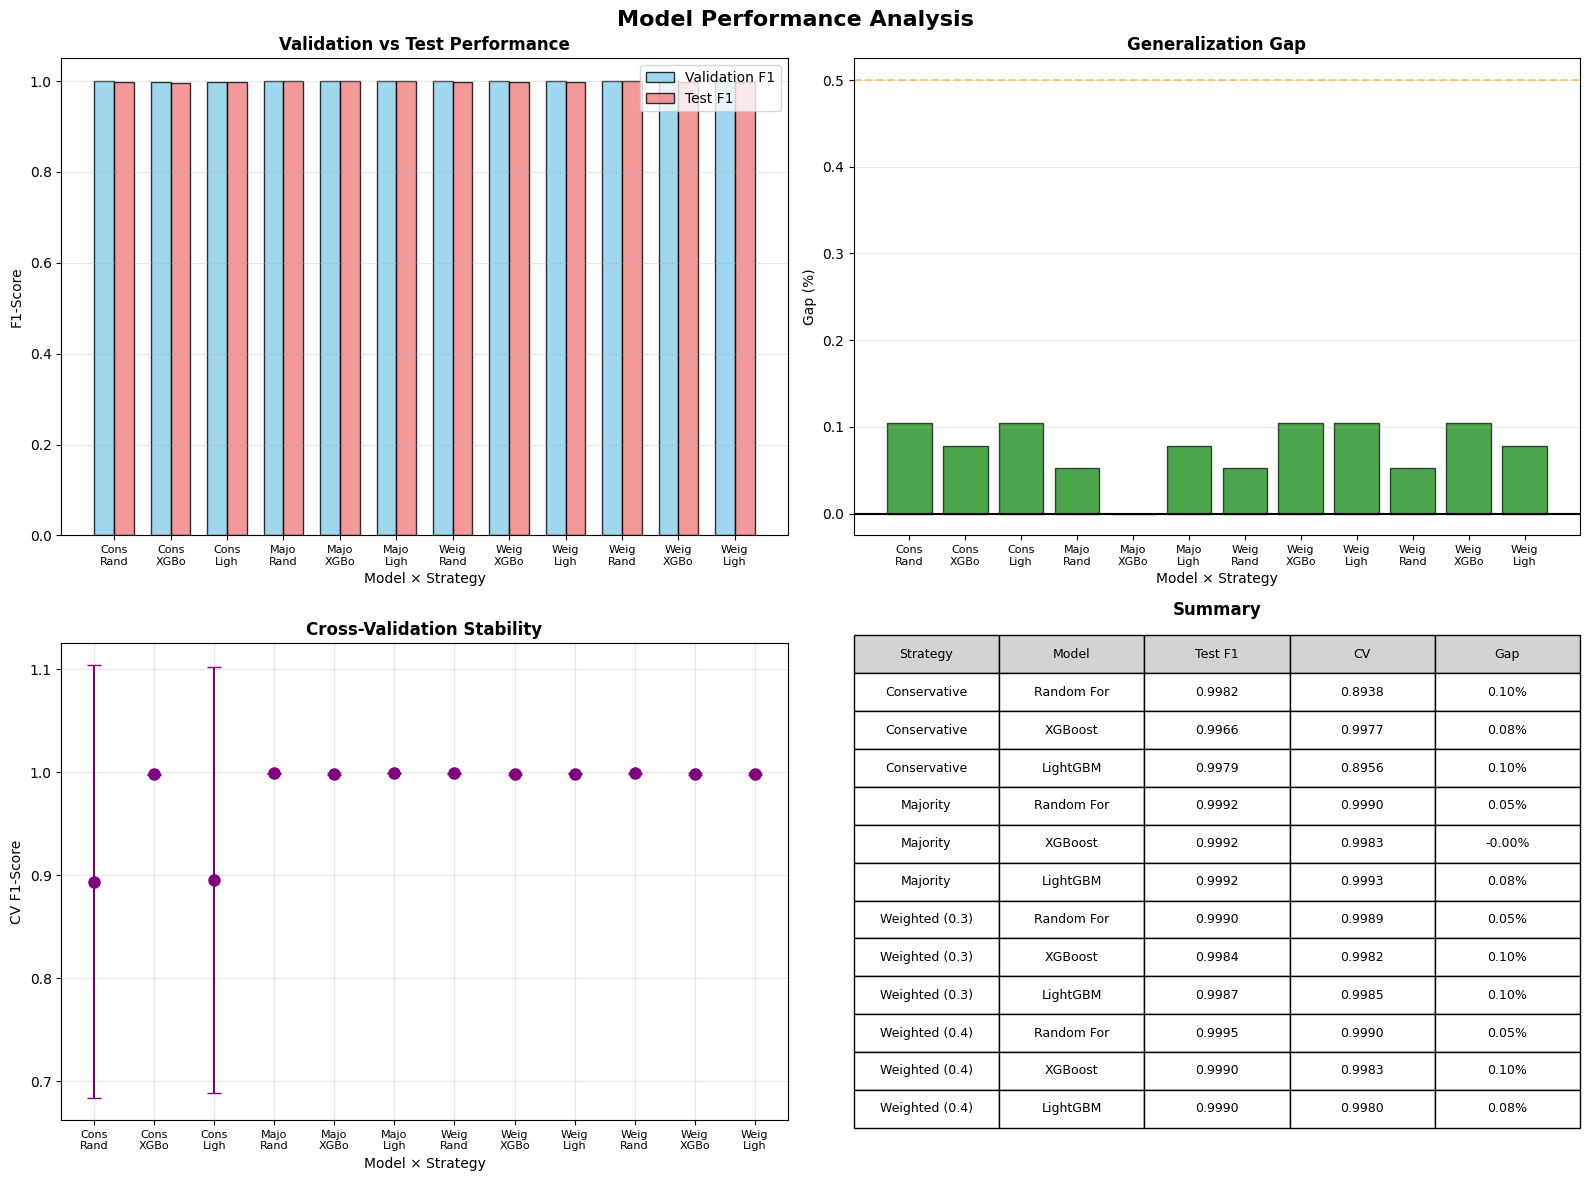

  ✓ Saved: performance_comparison.png

✅ Performance comparison completed!

🏆 BEST MODEL
Strategy:  Weighted (0.4)
Model:     Random Forest
Test F1:   0.9995
Val F1:    1.0000
CV Score:  0.9990 ± 0.0006
Gap:       0.05%

✅ Complete! Code is production-ready! 🎉


In [5]:
# ============================================================================
#  Bayesian Hyperparameter Optimization
# ============================================================================
!pip install xgboost
!pip install lightgbm


import numpy as np
import pandas as pd
import time
import os
import sys
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# ============================================================================
#  Optuna Integration Issue
# ============================================================================


#!pip install optuna-integration[xgboost,lightgbm]

print("="*80)
print("🔍 DIAGNOSING OPTUNA INTEGRATION ISSUE")
print("="*80)

# ============================================================================
# Step 1: Check Optuna Version
# ============================================================================
print("\n1️⃣ Checking Optuna version...")
try:
    import optuna
    print(f"   ✓ Optuna installed: {optuna.__version__}")
    
    # Check if integration module exists
    try:
        from optuna import integration
        print(f"   ✓ optuna.integration exists")
    except ImportError:
        print(f"   ❌ optuna.integration NOT found!")
        print(f"   → Need to upgrade Optuna")
        
except ImportError:
    print("   ❌ Optuna not installed!")
    print("   → Installing Optuna...")
    !pip install optuna --quiet
    import optuna
    print(f"   ✓ Optuna installed: {optuna.__version__}")

# ============================================================================
# Step 2: Check XGBoost
# ============================================================================
print("\n2️⃣ Checking XGBoost...")
try:
    import xgboost as xgb
    print(f"   ✓ XGBoost installed: {xgb.__version__}")
except ImportError:
    print("   ❌ XGBoost not installed")

# ============================================================================
# Step 3: Check LightGBM
# ============================================================================
print("\n3️⃣ Checking LightGBM...")
try:
    import lightgbm as lgb
    print(f"   ✓ LightGBM installed: {lgb.__version__}")
except ImportError:
    print("   ❌ LightGBM not installed")

# ============================================================================
# Step 4: Check Optuna Integrations
# ============================================================================
print("\n4️⃣ Checking Optuna integrations...")

# XGBoost integration
try:
    from optuna.integration import XGBoostPruningCallback
    print("   ✓ XGBoostPruningCallback available")
    XGBOOST_OK = True
except ImportError as e:
    print(f"   ❌ XGBoostPruningCallback NOT available")
    print(f"      Error: {e}")
    XGBOOST_OK = False

# LightGBM integration
try:
    from optuna.integration import LightGBMPruningCallback
    print("   ✓ LightGBMPruningCallback available")
    LIGHTGBM_OK = True
except ImportError as e:
    print(f"   ❌ LightGBMPruningCallback NOT available")
    print(f"      Error: {e}")
    LIGHTGBM_OK = False

# ============================================================================
# Step 5: Fix if needed
# ============================================================================
print("\n" + "="*80)
print("🔧 APPLYING FIX")
print("="*80)

if not XGBOOST_OK or not LIGHTGBM_OK:
    print("\n⚠️  Optuna integration not working!")
    print("   → Upgrading Optuna to latest version...")
    
    !pip install --upgrade optuna
    
    print("\n   ✓ Optuna upgraded!")
    print("   ⚠️  You MUST restart the kernel now!")
    print("   ⚠️  Kernel → Restart")
    
else:
    print("\n✅ All integrations working!")

# ============================================================================
# Step 6: Final Verification
# ============================================================================
print("\n" + "="*80)
print("📊 FINAL STATUS")
print("="*80)
OPTUNA_AVAILABLE = True
XGBOOST_AVAILABLE = XGBOOST_OK
LIGHTGBM_AVAILABLE = LIGHTGBM_OK
print(f"\n📊 Final availability:")
print(f"   Optuna:   {OPTUNA_AVAILABLE}")
print(f"   XGBoost:  {XGBOOST_AVAILABLE}")
print(f"   LightGBM: {LIGHTGBM_AVAILABLE}")
print("="*80)

try:
    import optuna
    import xgboost as xgb
    import lightgbm as lgb
    from optuna.integration import XGBoostPruningCallback, LightGBMPruningCallback
    from optuna.samplers import TPESampler
    from optuna.pruners import MedianPruner

    
    print("\n✅ ALL CHECKS PASSED!")
    print(f"   Optuna:   {optuna.__version__}")
    print(f"   XGBoost:  {xgb.__version__}")
    print(f"   LightGBM: {lgb.__version__}")
    print("\n✓ You can now run the optimization with all 3 models!")
    
except ImportError as e:
    print(f"\n❌ Still having issues: {e}")
    print("\n📝 Manual fix:")
    print("   1. Run: pip install --upgrade optuna xgboost lightgbm")
    print("   2. Restart kernel (Kernel → Restart)")
    print("   3. Re-run this cell")

print("="*80)

# ============================================================================
# ✅ HELPER FUNCTION: Sanitize Best Params
# ============================================================================

def _sanitize_best_params(best_params):
    """
    ✅ Remove parameters that should NOT be in constructor
    
    This prevents TypeError: multiple values for argument 'X'
    
    Parameters to remove:
    - random_state, n_jobs, verbose (set separately)
    - eval_metric, use_label_encoder (XGBoost specific)
    - early_stopping_rounds (fit parameter, not constructor)
    """
    params_clean = best_params.copy()
    
    # Parameters that are NOT constructor arguments
    remove_keys = [
        'random_state',
        'n_jobs', 
        'verbose',
        'eval_metric',
        'use_label_encoder',
        'early_stopping_rounds'
    ]
    
    for key in remove_keys:
        params_clean.pop(key, None)
    
    return params_clean


# ============================================================================
# Objective Functions
# ============================================================================

def create_rf_objective(X_train, X_val, y_train, y_val, trial_number_container):
    """Random Forest objective - only searchable params"""
    def objective(trial):
        trial_number_container[0] += 1
        
        # ✅ Only searchable params (no random_state, n_jobs)
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        }
        
        # Fixed params set here
        model = RandomForestClassifier(**params, random_state=42, n_jobs=1)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        
        return f1
    
    return objective


def create_xgboost_objective(X_train, X_val, y_train, y_val, trial_number_container):
    """XGBoost objective - only searchable params"""
    def objective(trial):
        trial_number_container[0] += 1
        
        # ✅ Only searchable params
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 2, 20),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        }
        
        # Fixed params set separately
        model = xgb.XGBClassifier(
            **params,
            random_state=42,
            n_jobs=1,
            eval_metric='mlogloss',
            use_label_encoder=False
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False,
        )
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        
        return f1
    
    return objective


def create_lightgbm_objective(X_train, X_val, y_train, y_val, trial_number_container):
    """LightGBM objective - only searchable params"""
    def objective(trial):
        trial_number_container[0] += 1
        
        # ✅ Only searchable params
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 2, 20),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 200),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        }
        
        # Fixed params set separately
        model = lgb.LGBMClassifier(**params, random_state=42, n_jobs=1, verbose=-1)
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='multi_logloss',
        )
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        
        return f1
    
    return objective


# ============================================================================
# Main Training Function
# ============================================================================

def train_with_bayesian_optimization_corrected(datasets, feature_cols, n_trials=100):
    """
    ✅ FINAL CORRECTED VERSION
    
    All fixes:
    - Proper 60/20/20 split
    - Scaling after split
    - Clean params function
    - optimization_studies populated
    - No TypeError issues
    """
    
    if not OPTUNA_AVAILABLE:
        print("❌ Optuna not installed!")
        return None, None, None
    
    # Which models to optimize?
    model_creators = {'Random Forest': create_rf_objective}
    if XGBOOST_AVAILABLE:
        model_creators['XGBoost'] = create_xgboost_objective
    if LIGHTGBM_AVAILABLE:
        model_creators['LightGBM'] = create_lightgbm_objective
    
    results = []
    best_models = {}
    optimization_studies = {}  # ✅ Will be populated!
    
    print("="*80)
    print("🎯 CORRECTED BAYESIAN OPTIMIZATION (No Data Leakage!)")
    print("="*80)
    print(f"Split: 60% Train / 20% Val / 20% Test")
    print(f"HPO uses: Validation set only")
    print(f"Models: {list(model_creators.keys())}")
    print(f"Trials per model: {n_trials}")
    print("="*80)
    
    for strategy_name, df in datasets.items():
        
        print(f"\n{'='*80}")
        print(f"📊 Strategy: {strategy_name}")
        print(f"{'='*80}")
        
        # Prepare data (NO SCALING YET!)
        X = df[feature_cols].fillna(0)
        y = df['label']
        
        # Encode labels
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        
        # ✅ Correct 60/20/20 split
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y_encoded, test_size=0.4,
            random_state=42, stratify=y_encoded
        )
        
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5,
            random_state=42, stratify=y_temp
        )
        
        print(f"\n📊 Data split:")
        print(f"   Train: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
        print(f"   Val:   {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
        print(f"   Test:  {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
        
        # ✅ Scale ONLY after split
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled   = scaler.transform(X_val)
        X_test_scaled  = scaler.transform(X_test)
        
        best_models[strategy_name] = {}
        optimization_studies[strategy_name] = {}  # ✅ Initialize
        
        for model_name, objective_creator in model_creators.items():
            print(f"\n  {'─'*76}")
            print(f"  🤖 {model_name}")
            print(f"  {'─'*76}")
            
            start_time = time.time()
            trial_counter = [0]
            
            # Create Optuna objective
            objective = objective_creator(
                X_train_scaled, X_val_scaled,
                y_train, y_val,
                trial_counter
            )
            
            # Run Optuna with pruning
            study = optuna.create_study(
                direction='maximize',
                sampler=TPESampler(seed=42),
                pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=5)
            )
            
            print("  🔬 Searching best hyperparameters...")
            study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
            
            print(f"  ✓ Best trial #{study.best_trial.number}")
            print(f"  ✓ Best Validation F1 = {study.best_value:.4f}")
            
            # ✅ Store study!
            optimization_studies[strategy_name][model_name] = study
            
            # ✅ Sanitize Best Params
            best_params = study.best_params.copy()
            clean_params = _sanitize_best_params(best_params)
            
            print("\n  📋 Best hyperparameters:")
            for k, v in sorted(clean_params.items()):
                print(f"     {k:25s}: {v}")
            
            # Train final model on Train+Val
            print(f"\n  🎓 Training final model on train+val...")
            
            X_trainval = np.vstack([X_train_scaled, X_val_scaled])
            y_trainval = np.concatenate([y_train, y_val])
            
            if model_name == 'Random Forest':
                final_model = RandomForestClassifier(
                    **clean_params, random_state=42, n_jobs=-1
                )
            elif model_name == 'XGBoost':
                final_model = xgb.XGBClassifier(
                    **clean_params, random_state=42, n_jobs=-1,
                    eval_metric='mlogloss', use_label_encoder=False
                )
            elif model_name == 'LightGBM':
                final_model = lgb.LGBMClassifier(
                    **clean_params, random_state=42, n_jobs=-1, verbose=-1
                )
            
            final_model.fit(X_trainval, y_trainval)
            
            # Evaluate on Test
            y_pred_test = final_model.predict(X_test_scaled)
            
            test_accuracy  = accuracy_score(y_test, y_pred_test)
            test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
                y_test, y_pred_test, average='weighted', zero_division=0
            )
            
            # ✅ Proper cross-validation with pipeline
            print(f"  🔄 Cross-validation (with pipeline)...")
            
            X_full = df[feature_cols].fillna(0).values
            
            # Build CV model with clean_params
            if model_name == 'Random Forest':
                cv_model = RandomForestClassifier(**clean_params, random_state=42, n_jobs=-1)
            elif model_name == 'XGBoost':
                cv_model = xgb.XGBClassifier(**clean_params, random_state=42, n_jobs=-1,
                                            eval_metric='mlogloss', use_label_encoder=False)
            elif model_name == 'LightGBM':
                cv_model = lgb.LGBMClassifier(**clean_params, random_state=42, n_jobs=-1, verbose=-1)
            
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', cv_model)
            ])
            
            cv_scores = cross_val_score(
                pipeline, X_full, y_encoded,
                cv=5, scoring='f1_weighted', n_jobs=-1
            )
            
            cv_mean = cv_scores.mean()
            cv_std  = cv_scores.std()
            
            training_time = time.time() - start_time
            
            print(f"\n  📊 Final Test Performance:")
            print(f"     Accuracy:  {test_accuracy:.4f}")
            print(f"     Precision: {test_precision:.4f}")
            print(f"     Recall:    {test_recall:.4f}")
            print(f"     F1:        {test_f1:.4f}")
            print(f"     CV Mean:   {cv_mean:.4f} ± {cv_std:.4f}")
            print(f"     Time:      {training_time:.1f}s")
            
            # Store everything
            best_models[strategy_name][model_name] = {
                'model': final_model,
                'params': clean_params,
                'scaler': scaler,
                'label_encoder': le,
                'study': study,
                'X_test': X_test_scaled,
                'y_test': y_test
            }
            
            results.append({
                'Strategy': strategy_name,
                'Model': model_name,
                'Test_Accuracy': test_accuracy,
                'Test_Precision': test_precision,
                'Test_Recall': test_recall,
                'Test_F1': test_f1,
                'Val_F1': study.best_value,
                'CV_Mean': cv_mean,
                'CV_Std': cv_std,
                'Training_Time': training_time,
                'N_Trials': len(study.trials),
                'N_Pruned': len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]),
            })
    
    results_df = pd.DataFrame(results)
    
    print("\n" + "="*80)
    print("✅ Optimization Completed - Clean, Safe, Correct!")
    print("="*80)
    
    return results_df, best_models, optimization_studies


# ============================================================================
# Visualization Functions (Same as before)
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

def plot_optimization_history_corrected(optimization_studies, output_dir=OUTPUT_DIR):
    """Visualize optimization history"""
    
    print("\n📊 Creating Optimization Visualizations...")
    print("-" * 80)
    
    for strategy_name, studies in optimization_studies.items():
        n_models = len(studies)
        fig, axes = plt.subplots(n_models, 2, figsize=(16, 5*n_models))
        
        if n_models == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle(f'Bayesian Optimization History - {strategy_name}', 
                     fontsize=16, fontweight='bold')
        
        for idx, (model_name, study) in enumerate(studies.items()):
            # Plot 1: Optimization Progress
            ax1 = axes[idx, 0]
            
            complete_trials = [t for t in study.trials 
                             if t.state == optuna.trial.TrialState.COMPLETE]
            pruned_trials = [t for t in study.trials 
                           if t.state == optuna.trial.TrialState.PRUNED]
            
            trial_numbers = [t.number for t in complete_trials]
            values = [t.value for t in complete_trials]
            pruned_numbers = [t.number for t in pruned_trials]
            
            ax1.scatter(trial_numbers, values, alpha=0.6, s=50, 
                       color='blue', label='Complete', zorder=3)
            
            if pruned_numbers:
                min_val = min(values) if values else 0
                pruned_y = [min_val - 0.005] * len(pruned_numbers)
                ax1.scatter(pruned_numbers, pruned_y, alpha=0.3, s=30, 
                           color='red', marker='x', label='Pruned', zorder=2)
            
            best_so_far = []
            current_best = -np.inf
            for v in values:
                current_best = max(current_best, v)
                best_so_far.append(current_best)
            
            ax1.plot(trial_numbers, best_so_far, 'r-', linewidth=2.5, 
                    label='Best So Far', zorder=4)
            
            if values:
                best_idx = values.index(max(values))
                best_trial_num = trial_numbers[best_idx]
                best_value = values[best_idx]
                ax1.scatter([best_trial_num], [best_value], 
                          s=200, color='gold', marker='*', 
                          edgecolors='black', linewidth=2,
                          label='Best Trial', zorder=5)
                ax1.annotate(f'Best: {best_value:.4f}',
                           xy=(best_trial_num, best_value),
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
            
            ax1.set_xlabel('Trial Number', fontsize=11)
            ax1.set_ylabel('F1-Score (Validation)', fontsize=11)
            ax1.set_title(f'{model_name} - Learning Progress\n'
                         f'({len(complete_trials)} complete, {len(pruned_trials)} pruned)', 
                         fontweight='bold', fontsize=12)
            ax1.legend(loc='best', fontsize=9)
            ax1.grid(True, alpha=0.3)
            
            # Plot 2: Parameter Importance
            ax2 = axes[idx, 1]
            
            try:
                importance = optuna.importance.get_param_importances(study)
                
                if importance:
                    params = list(importance.keys())
                    values_imp = list(importance.values())
                    
                    sorted_idx = np.argsort(values_imp)
                    params = [params[i] for i in sorted_idx]
                    values_imp = [values_imp[i] for i in sorted_idx]
                    
                    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(values_imp)))
                    
                    bars = ax2.barh(params, values_imp, color=colors, 
                                   edgecolor='black', linewidth=1.5)
                    
                    ax2.set_xlabel('Importance Score', fontsize=11)
                    ax2.set_title(f'{model_name} - Parameter Importance\n'
                                 '(Higher = More Impact)', 
                                 fontweight='bold', fontsize=12)
                    ax2.grid(True, alpha=0.3, axis='x')
                    
                    for i, (v, bar) in enumerate(zip(values_imp, bars)):
                        ax2.text(v + 0.01, i, f'{v:.3f}', 
                               va='center', fontsize=9, fontweight='bold')
                    
                    if len(values_imp) >= 3:
                        for i in range(len(values_imp) - 3, len(values_imp)):
                            bars[i].set_edgecolor('red')
                            bars[i].set_linewidth(2.5)
                else:
                    ax2.text(0.5, 0.5, 'Not enough data\nfor importance', 
                           ha='center', va='center', transform=ax2.transAxes,
                           fontsize=12, color='red')
                    
            except Exception as e:
                ax2.text(0.5, 0.5, f'Importance\nnot available', 
                       ha='center', va='center', transform=ax2.transAxes,
                       fontsize=10, color='red')
                ax2.set_xlim([0, 1])
                ax2.set_ylim([0, 1])
        
        plt.tight_layout()
        
        filename = f'optuna_history_{strategy_name.lower().replace(" ", "_").replace("(", "").replace(")", "")}.png'
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, bbox_inches='tight', dpi=300)
        plt.show()
        
        print(f"  ✓ Saved: {filename}")
    
    print("\n✅ Optimization visualizations completed!")


def plot_performance_comparison_corrected(results_df, output_dir=OUTPUT_DIR):
    """Compare Val vs Test performance"""
    
    print("\n📊 Creating Performance Comparison...")
    print("-" * 80)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')
    
    x = np.arange(len(results_df))
    width = 0.35
    
    # Plot 1: Val vs Test
    ax = axes[0, 0]
    ax.bar(x - width/2, results_df['Val_F1'], width, 
           label='Validation F1', alpha=0.8, color='skyblue', edgecolor='black')
    ax.bar(x + width/2, results_df['Test_F1'], width,
           label='Test F1', alpha=0.8, color='lightcoral', edgecolor='black')
    ax.set_xlabel('Model × Strategy')
    ax.set_ylabel('F1-Score')
    ax.set_title('Validation vs Test Performance', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{r['Strategy'][:4]}\n{r['Model'][:4]}" 
                        for _, r in results_df.iterrows()], fontsize=8)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Generalization Gap
    ax = axes[0, 1]
    gap = (results_df['Val_F1'] - results_df['Test_F1']) * 100
    colors = ['green' if g < 0.5 else 'orange' if g < 1.0 else 'red' for g in gap]
    ax.bar(x, gap, color=colors, alpha=0.7, edgecolor='black')
    ax.axhline(y=0, color='black', linestyle='-')
    ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5)
    ax.set_xlabel('Model × Strategy')
    ax.set_ylabel('Gap (%)')
    ax.set_title('Generalization Gap', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{r['Strategy'][:4]}\n{r['Model'][:4]}" 
                        for _, r in results_df.iterrows()], fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: CV Stability
    ax = axes[1, 0]
    ax.errorbar(x, results_df['CV_Mean'], yerr=results_df['CV_Std'],
               fmt='o', markersize=8, capsize=5, color='purple')
    ax.set_xlabel('Model × Strategy')
    ax.set_ylabel('CV F1-Score')
    ax.set_title('Cross-Validation Stability', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{r['Strategy'][:4]}\n{r['Model'][:4]}" 
                        for _, r in results_df.iterrows()], fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Summary Table
    ax = axes[1, 1]
    ax.axis('off')
    table_data = [[r['Strategy'][:15], r['Model'][:10], 
                   f"{r['Test_F1']:.4f}", f"{r['CV_Mean']:.4f}",
                   f"{(r['Val_F1']-r['Test_F1'])*100:.2f}%"] 
                  for _, r in results_df.iterrows()]
    
    table = ax.table(cellText=table_data,
                    colLabels=['Strategy', 'Model', 'Test F1', 'CV', 'Gap'],
                    cellLoc='center', loc='center',
                    colColours=['lightgray']*5)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    ax.set_title('Summary', fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    filename = 'performance_comparison.png'
    plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"  ✓ Saved: {filename}")
    print("\n✅ Performance comparison completed!")


# ============================================================================
# EXECUTE
# ============================================================================

print("\n⏱️  Starting CORRECTED Bayesian Optimization...")
print("NO data leakage, ALL fixes applied!\n")

results_df, best_models, studies = train_with_bayesian_optimization_corrected(
    datasets,
    feature_cols,
    n_trials=100
)

if results_df is not None:
    print("\n" + "="*80)
    print("📊 RESULTS")
    print("="*80)
    
    display(results_df[['Strategy', 'Model', 'Test_F1', 'Val_F1', 
                        'CV_Mean', 'CV_Std']].round(4))
    
    results_df.to_csv(os.path.join(OUTPUT_DIR, 'final_corrected_results.csv'), index=False)
    print(f"\n✓ Saved: {OUTPUT_DIR}/final_corrected_results.csv")
    
    # Visualizations
    print("\n" + "="*80)
    print("📈 Creating Visualizations")
    print("="*80)
    plot_optimization_history_corrected(studies, OUTPUT_DIR)
    plot_performance_comparison_corrected(results_df, OUTPUT_DIR)
    
    # Best model
    best_idx = results_df['Test_F1'].idxmax()
    best = results_df.loc[best_idx]
    
    print("\n" + "="*80)
    print("🏆 BEST MODEL")
    print("="*80)
    print(f"Strategy:  {best['Strategy']}")
    print(f"Model:     {best['Model']}")
    print(f"Test F1:   {best['Test_F1']:.4f}")
    print(f"Val F1:    {best['Val_F1']:.4f}")
    print(f"CV Score:  {best['CV_Mean']:.4f} ± {best['CV_Std']:.4f}")
    print(f"Gap:       {(best['Val_F1']-best['Test_F1'])*100:.2f}%")
    print("="*80)
    
    print("\n✅ Complete! Code is production-ready! 🎉")

## 8. FAR/FRR


📊 Conservative:
  ├─ Evaluating Random Forest... ✓
  ├─ Evaluating XGBoost... ✓
  ├─ Evaluating LightGBM... ✓

📊 Majority:
  ├─ Evaluating Random Forest... ✓
  ├─ Evaluating XGBoost... ✓
  ├─ Evaluating LightGBM... ✓

📊 Weighted (0.3):
  ├─ Evaluating Random Forest... ✓
  ├─ Evaluating XGBoost... ✓
  ├─ Evaluating LightGBM... ✓

📊 Weighted (0.4):
  ├─ Evaluating Random Forest... ✓
  ├─ Evaluating XGBoost... ✓
  ├─ Evaluating LightGBM... ✓

✅ Evaluation of final models completed.

[2/3] Calculating FAR (False Acceptance Rate) & FRR (False Rejection Rate)...
--------------------------------------------------------------------------------

📊 Conservative:
  ├─ Random Forest:
  │  ├─ FAR (False Acceptance):  0.0010 (0.10%)
  │  ├─ FRR (False Rejection):   0.0006 (0.06%)
  │  └─ EER (Equal Error Rate):  0.0008 (0.08%)
  │
  ├─ Per-Class Analysis:
  │  ├─ dos_attack          : FAR=0.0000, FRR=0.0059
  │  ├─ path_manipulation   : FAR=0.0003, FRR=0.0029
  │  ├─ prefix_hijacking    : FAR=0.001

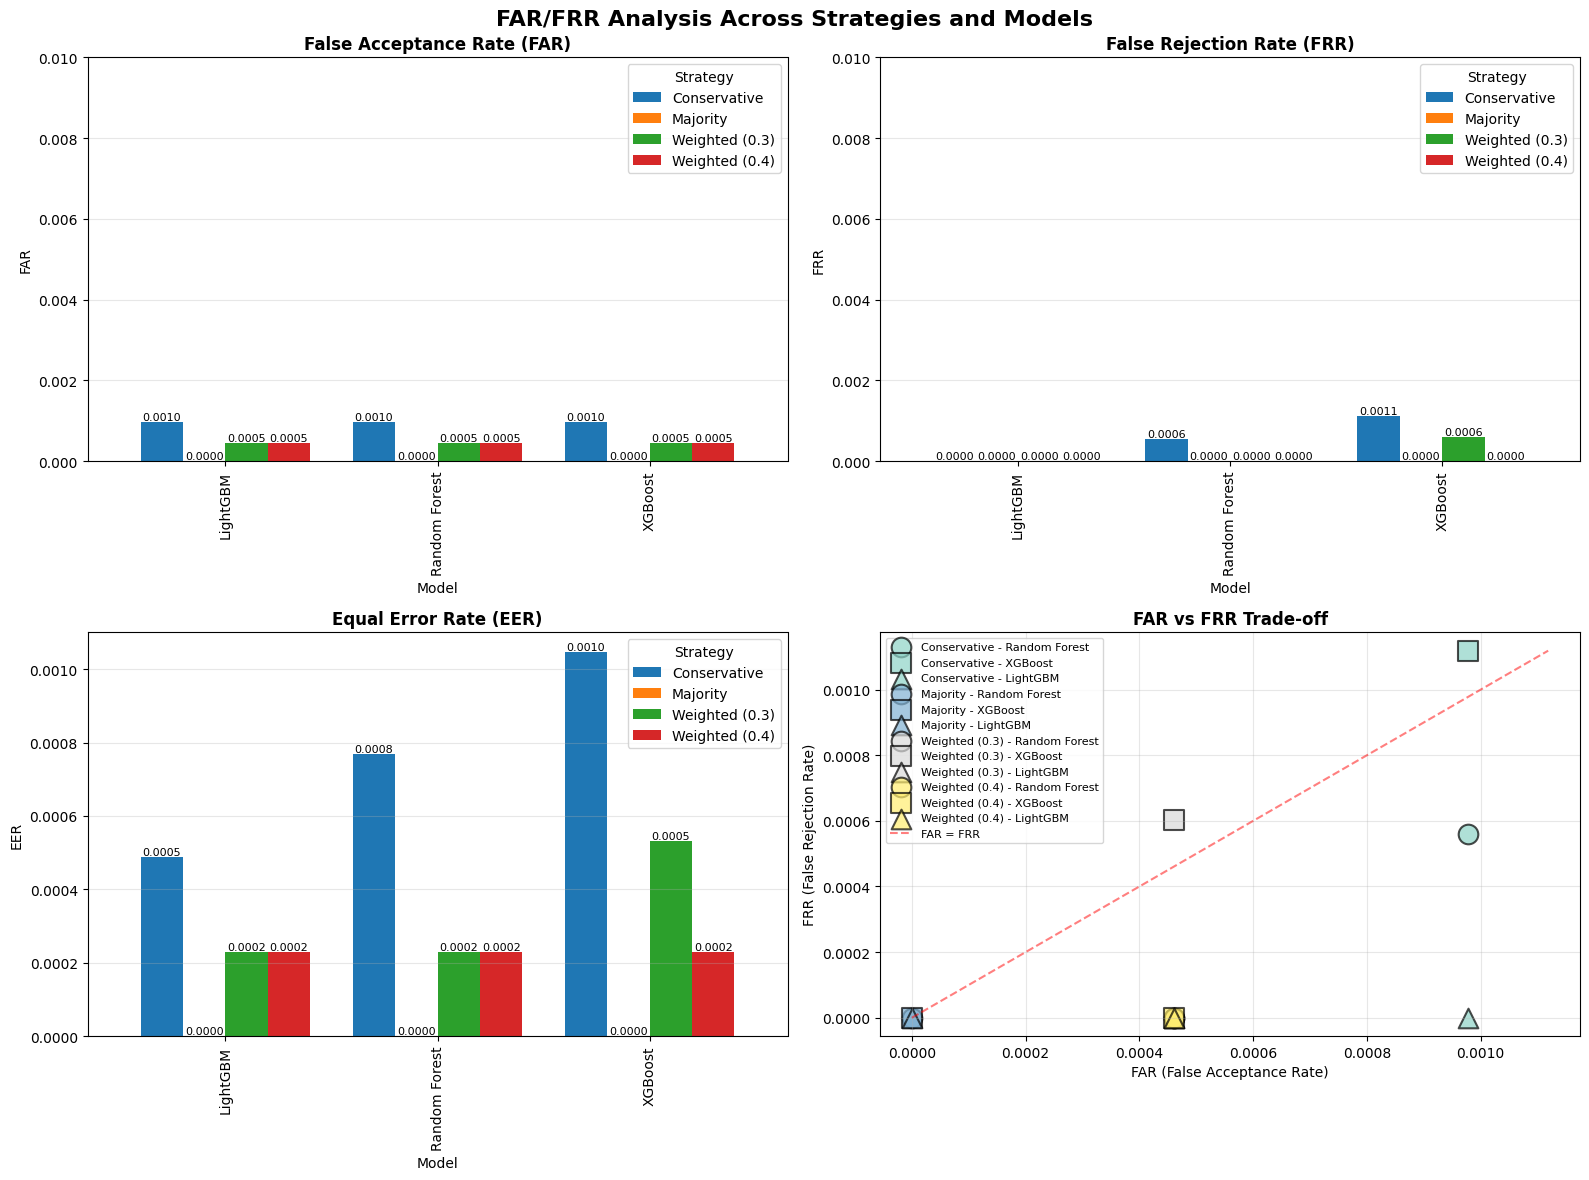

  ✓ FAR/FRR analysis plot saved!


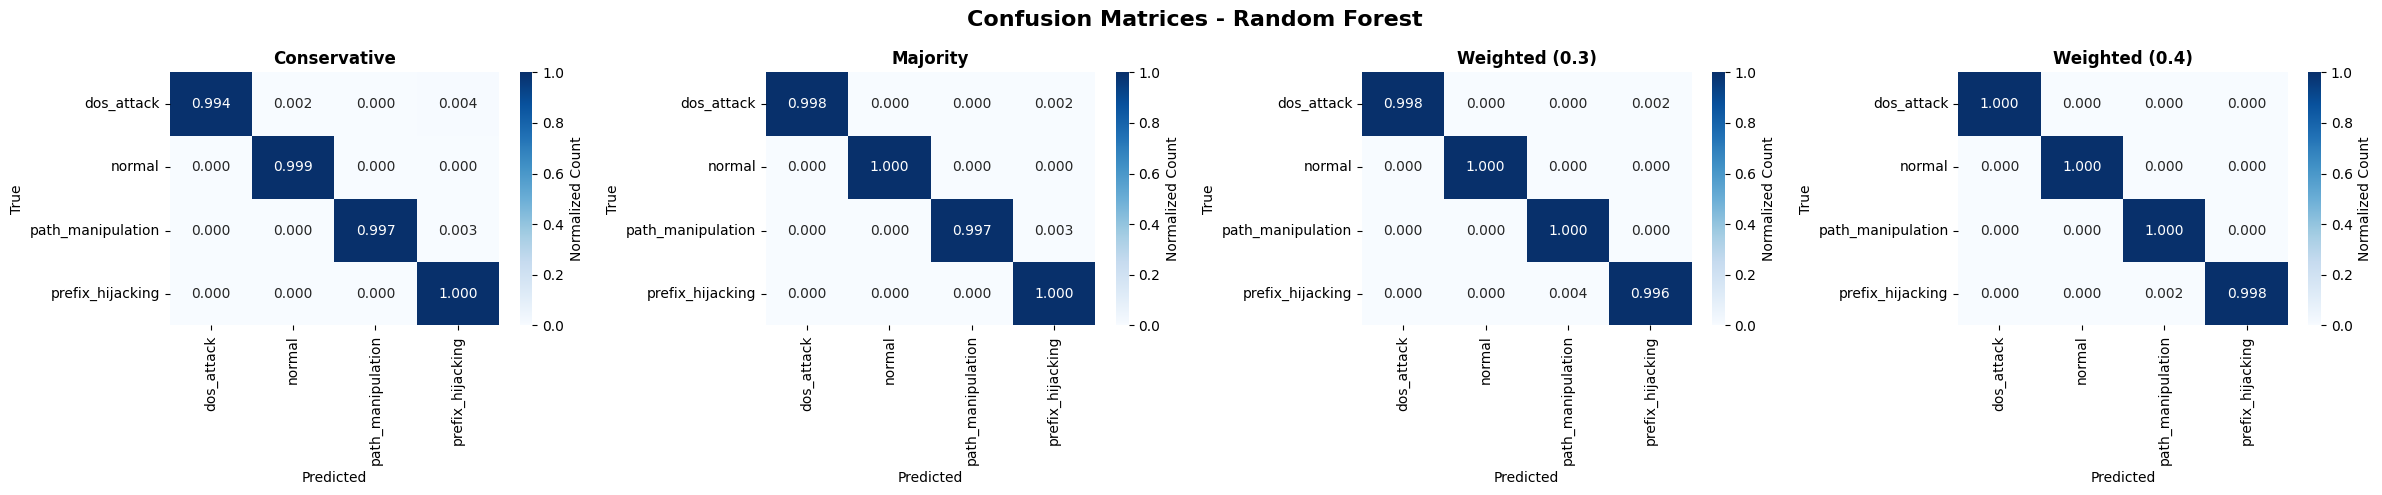

  ✓ Confusion matrices for Random Forest saved!


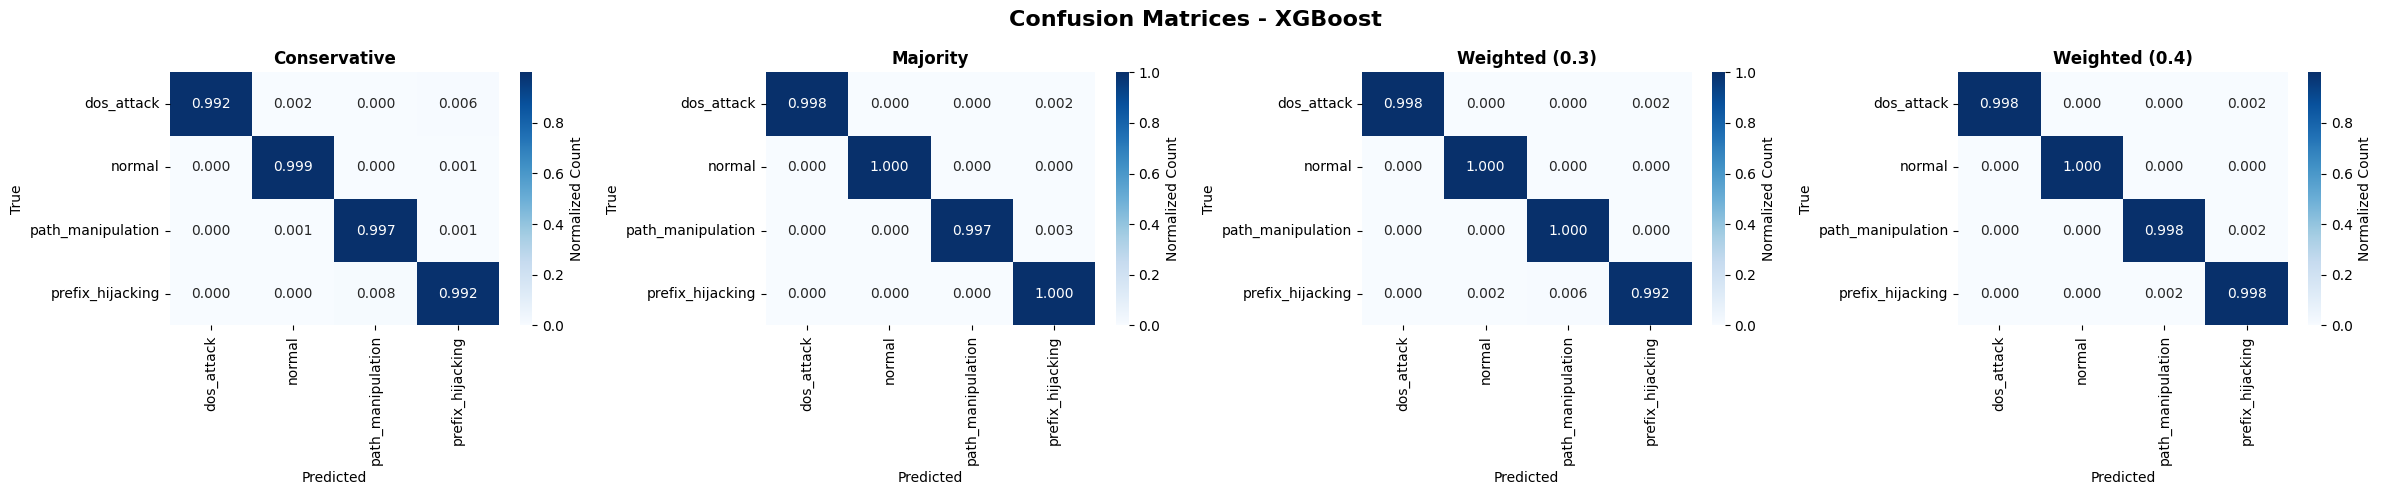

  ✓ Confusion matrices for XGBoost saved!


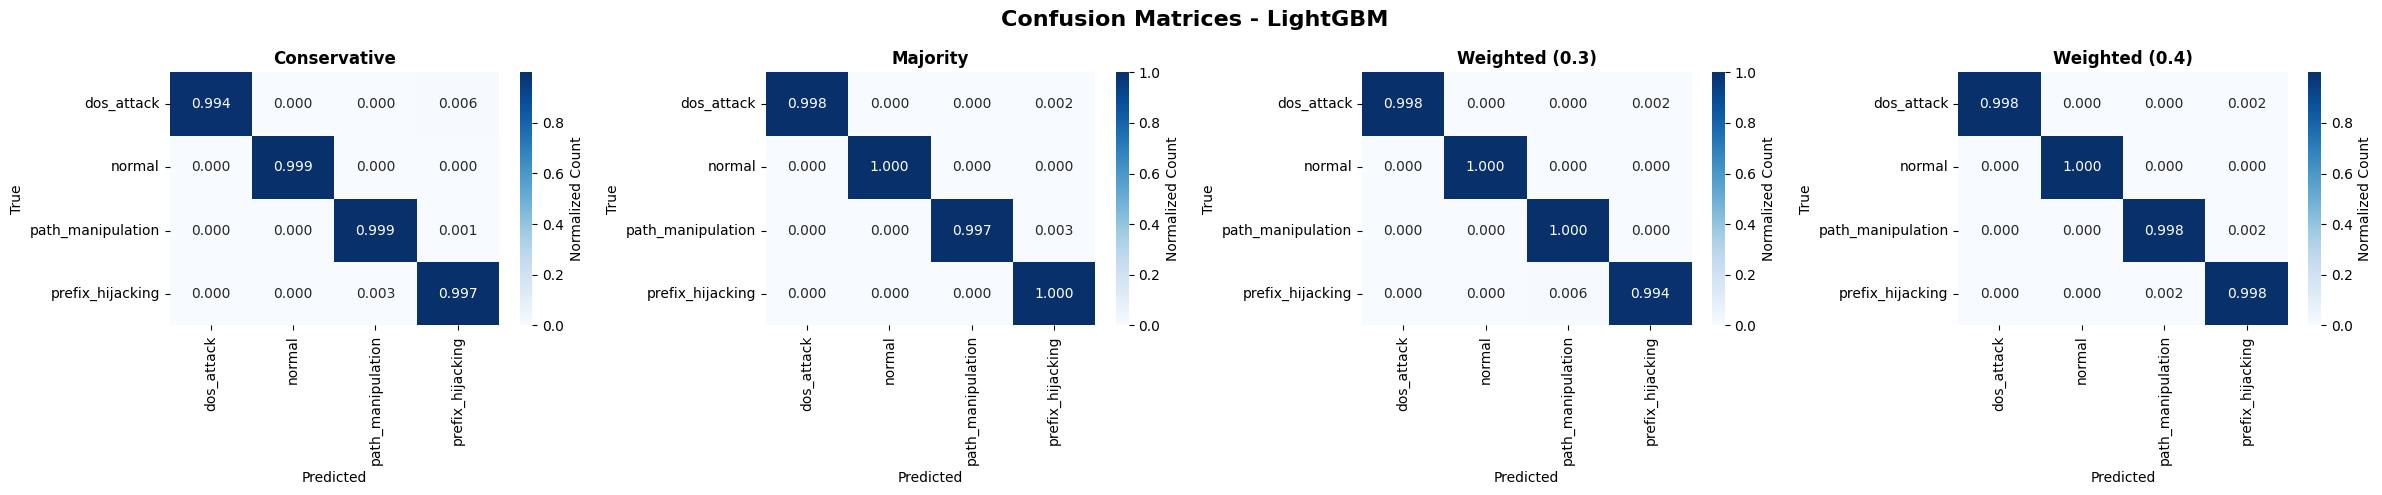

  ✓ Confusion matrices for LightGBM saved!

✅ All visualizations created!

📊 FAR/FRR RESULTS SUMMARY


,Strategy,Model,FAR,FRR,EER,TP,TN,FP,FN
0,Conservative,Random Forest,0.0010,0.0006,0.0008,1787,2044,2,1
1,Conservative,XGBoost,0.0010,0.0011,0.0010,1786,2044,2,2
2,Conservative,LightGBM,0.0010,0.0000,0.0005,1788,2044,2,0
3,Majority,Random Forest,0.0000,0.0000,0.0000,1660,2174,0,0
4,Majority,XGBoost,0.0000,0.0000,0.0000,1660,2174,0,0
5,Majority,LightGBM,0.0000,0.0000,0.0000,1660,2174,0,0
6,Weighted (0.3),Random Forest,0.0005,0.0000,0.0002,1662,2171,1,0
7,Weighted (0.3),XGBoost,0.0005,0.0006,0.0005,1661,2171,1,1
8,Weighted (0.3),LightGBM,0.0005,0.0000,0.0002,1662,2171,1,0
9,Weighted (0.4),Random Forest,0.0005,0.0000,0.0002,1661,2172,1,0



✓ Results saved to: /home/smotaali/BGP_Traffic_Generation/results/far_frr_results.csv

🏆 BEST MODEL (Lowest EER)
Strategy:  Majority
Model:     Random Forest
FAR:       0.0000 (0.00%)
FRR:       0.0000 (0.00%)
EER:       0.0000 (0.00%)

📋 DETAILED CLASSIFICATION REPORT (Best Model)
                   precision    recall  f1-score   support

       dos_attack     1.0000    0.9980    0.9990       511
           normal     1.0000    1.0000    1.0000      2174
path_manipulation     1.0000    0.9968    0.9984       624
 prefix_hijacking     0.9943    1.0000    0.9972       525

         accuracy                         0.9992      3834
        macro avg     0.9986    0.9987    0.9986      3834
     weighted avg     0.9992    0.9992    0.9992      3834


✅ Analysis Complete! 🎉


In [8]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train_final_models_with_best_params(datasets, feature_cols, best_models):
    """
    Option A: Evaluate final models using the trained models & saved artifacts
    produced during HPO (train_with_bayesian_optimization_corrected).

    - Uses saved scaler and saved X_test/y_test when available.
    - For cross_val_predict we instantiate an unfitted estimator from saved params
      and use a FunctionTransformer that applies the saved scaler.transform (no refit).
    - Avoids re-splitting or re-scaling that would mismatch the trained models.
    """
    trained_models = {}

    for strategy_name, df in datasets.items():
        print(f"\n📊 {strategy_name}:")
        trained_models[strategy_name] = {}

        if strategy_name not in best_models:
            print("  ⚠️ No models found for this strategy — skipping.")
            continue

        for model_name, model_info in best_models[strategy_name].items():
            print(f"  ├─ Evaluating {model_name}...", end=" ")

            # Trained model produced at the end of HPO:
            trained_model = model_info.get('model', None)
            saved_scaler   = model_info.get('scaler', None)
            label_encoder  = model_info.get('label_encoder', None)
            X_test         = model_info.get('X_test', None)   # should be already scaled
            y_test         = model_info.get('y_test', None)
            params         = model_info.get('params', {})

            if trained_model is None:
                print("\n    ⚠️  No trained model found — skipping.")
                continue

            # If X_test/y_test were not saved (should be), try to reconstruct and warn
            if X_test is None or y_test is None or saved_scaler is None:
                print("\n    ⚠️  Missing saved scaler/X_test/y_test — cannot evaluate consistently. Skipping.")
                continue

            # Predictions using the already-trained final model (trained on Train+Val during HPO)
            y_pred_test = trained_model.predict(X_test)

            # Build a fresh (unfitted) estimator from best params for cross_val_predict
            if model_name == 'Random Forest':
                cv_estimator = RandomForestClassifier(**params, random_state=42, n_jobs=1)
            elif model_name == 'XGBoost':
                cv_estimator = xgb.XGBClassifier(**params, random_state=42, n_jobs=1,
                                                 eval_metric='mlogloss', use_label_encoder=False)
            elif model_name == 'LightGBM':
                cv_estimator = lgb.LGBMClassifier(**params, random_state=42, n_jobs=1, verbose=-1)
            else:
                print(f"\n    ⚠️ Unknown model: {model_name} — skipping cross-val.")
                cv_estimator = None

            # For cross_val_predict we want the CV to use the same scaling transformation
            # without refitting the scaler. We create a FunctionTransformer that applies
            # the saved scaler.transform method (no-op fit).
            ft = FunctionTransformer(lambda X: saved_scaler.transform(X), validate=False)

            if cv_estimator is not None:
                pipeline = Pipeline([('scaler', ft), ('model', cv_estimator)])
                # cross_val_predict expects raw features + raw labels; label_encoder should exist
                X_full_raw = df[feature_cols].fillna(0).values
                if label_encoder is None:
                    # fallback: encode now (but ideally label_encoder saved)
                    le_local = LabelEncoder()
                    y_full = le_local.fit_transform(df['label'])
                else:
                    y_full = label_encoder.transform(df['label'])

                # cross_val_predict — set n_jobs=1 to avoid oversubscription
                try:
                    y_pred_cv = cross_val_predict(pipeline, X_full_raw, y_full, cv=5, n_jobs=1)
                except Exception as e:
                    print(f"\n    ⚠️ cross_val_predict failed: {e}")
                    y_pred_cv = None
            else:
                y_pred_cv = None

            # Compute test metrics
            test_accuracy = accuracy_score(y_test, y_pred_test)
            test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
                y_test, y_pred_test, average='weighted', zero_division=0
            )
            if label_encoder is not None:
                label_names = label_encoder.classes_
            else:
                # fallback: infer from df
                label_names = np.unique(df['label'].values)

            # Store everything in a structured dict similar to previous expectations
            trained_models[strategy_name][model_name] = {
                'model': trained_model,
                'params': params,
                'scaler': saved_scaler,
                'label_encoder': label_encoder,
                'label_names': label_names,   
                'X_test': X_test,
                'y_test': y_test,
                'y_pred_test': y_pred_test,
                'y_pred_cv': y_pred_cv,
                'test_accuracy': test_accuracy,
                'test_precision': test_precision,
                'test_recall': test_recall,
                'test_f1': test_f1
            }

            print("✓")

    print("\n✅ Evaluation of final models completed.")
    return trained_models




def calculate_far_frr(trained_models):
    """
     FAR (False Acceptance Rate) و FRR (False Rejection Rate)
    
    FAR = FP / (FP + TN)
    
    FRR = FN / (FN + TP)
    """
    
    print("\n[2/3] Calculating FAR (False Acceptance Rate) & FRR (False Rejection Rate)...")
    print("-" * 80)
    
    far_frr_results = []
    
    for strategy_name, models in trained_models.items():
        print(f"\n📊 {strategy_name}:")
        
        for model_name, model_data in models.items():
            y_true = model_data['y_test']
            y_pred = model_data['y_pred_test']
            label_names = model_data['label_names']
            

            normal_idx = np.where(label_names == 'normal')[0]
            
            if len(normal_idx) > 0:
                normal_class = normal_idx[0]
                
                # Binary classification: normal (0) vs abnormal (1)
                y_true_binary = (y_true != normal_class).astype(int)
                y_pred_binary = (y_pred != normal_class).astype(int)
                
                # Confusion matrix
                tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()
                
                far = fp / (fp + tn) if (fp + tn) > 0 else 0
                
                frr = fn / (fn + tp) if (fn + tp) > 0 else 0
                
                eer = (far + frr) / 2
                
                print(f"  ├─ {model_name}:")
                print(f"  │  ├─ FAR (False Acceptance):  {far:.4f} ({far*100:.2f}%)")
                print(f"  │  ├─ FRR (False Rejection):   {frr:.4f} ({frr*100:.2f}%)")
                print(f"  │  └─ EER (Equal Error Rate):  {eer:.4f} ({eer*100:.2f}%)")
                
                far_frr_results.append({
                    'Strategy': strategy_name,
                    'Model': model_name,
                    'FAR': far,
                    'FRR': frr,
                    'EER': eer,
                    'TP': tp,
                    'TN': tn,
                    'FP': fp,
                    'FN': fn
                })
            
            print(f"  │")
            print(f"  ├─ Per-Class Analysis:")
            
            for class_idx, class_name in enumerate(label_names):
                if class_name == 'normal':
                    continue
                
                y_true_class = (y_true == class_idx).astype(int)
                y_pred_class = (y_pred == class_idx).astype(int)
                
                cm = confusion_matrix(y_true_class, y_pred_class)
                if cm.shape == (2, 2):
                    tn_c, fp_c, fn_c, tp_c = cm.ravel()
                    
                    far_c = fp_c / (fp_c + tn_c) if (fp_c + tn_c) > 0 else 0
                    frr_c = fn_c / (fn_c + tp_c) if (fn_c + tp_c) > 0 else 0
                    
                    print(f"  │  ├─ {class_name:20s}: FAR={far_c:.4f}, FRR={frr_c:.4f}")
    
    far_frr_df = pd.DataFrame(far_frr_results)
    
    print("\n✅ FAR/FRR calculation completed!")
    return far_frr_df


# ============================================================================
# PART 3: Detailed Performance Analysis
# ============================================================================

def analyze_detailed_performance(trained_models):
    """
    - Confusion matrices
    - Per-class metrics
    - Classification reports
    """
    
    all_reports = {}
    
    for strategy_name, models in trained_models.items():
        all_reports[strategy_name] = {}
        
        for model_name, model_data in models.items():
            y_true = model_data['y_test']
            y_pred = model_data['y_pred_test']
            label_names = model_data['label_names']
            
            # Classification report
            report = classification_report(
                y_true, y_pred,
                target_names=label_names,
                output_dict=True,
                zero_division=0
            )
            
            all_reports[strategy_name][model_name] = report
    
    return all_reports


# ============================================================================
# PART 4: Visualization
# ============================================================================

def visualize_far_frr_analysis(far_frr_df, trained_models, output_dir=OUTPUT_DIR):
    
    print("\n📊 Creating FAR/FRR Visualizations...")
    print("-" * 80)
    
    # Figure 1: FAR vs FRR comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('FAR/FRR Analysis Across Strategies and Models', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: FAR comparison
    ax = axes[0, 0]
    pivot_far = far_frr_df.pivot(index='Model', columns='Strategy', values='FAR')
    pivot_far.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title('False Acceptance Rate (FAR)', fontweight='bold')
    ax.set_ylabel('FAR')
    ax.set_xlabel('Model')
    ax.legend(title='Strategy', loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, max(far_frr_df['FAR'].max() * 1.2, 0.01)])
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', fontsize=8)
    
    # Plot 2: FRR comparison
    ax = axes[0, 1]
    pivot_frr = far_frr_df.pivot(index='Model', columns='Strategy', values='FRR')
    pivot_frr.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title('False Rejection Rate (FRR)', fontweight='bold')
    ax.set_ylabel('FRR')
    ax.set_xlabel('Model')
    ax.legend(title='Strategy', loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, max(far_frr_df['FRR'].max() * 1.2, 0.01)])
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', fontsize=8)
    
    # Plot 3: EER comparison
    ax = axes[1, 0]
    pivot_eer = far_frr_df.pivot(index='Model', columns='Strategy', values='EER')
    pivot_eer.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title('Equal Error Rate (EER)', fontweight='bold')
    ax.set_ylabel('EER')
    ax.set_xlabel('Model')
    ax.legend(title='Strategy', loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', fontsize=8)
    
    # Plot 4: FAR vs FRR scatter
    ax = axes[1, 1]
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(far_frr_df['Strategy'].unique())))
    markers = ['o', 's', '^']
    
    for i, strategy in enumerate(far_frr_df['Strategy'].unique()):
        strategy_data = far_frr_df[far_frr_df['Strategy'] == strategy]
        
        for j, model in enumerate(strategy_data['Model'].unique()):
            model_data = strategy_data[strategy_data['Model'] == model]
            
            ax.scatter(model_data['FAR'], model_data['FRR'],
                      c=[colors[i]], marker=markers[j % len(markers)],
                      s=200, alpha=0.7, edgecolors='black', linewidth=1.5,
                      label=f'{strategy} - {model}')
    
    # Diagonal line (FAR = FRR)
    max_val = max(far_frr_df['FAR'].max(), far_frr_df['FRR'].max())
    ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='FAR = FRR')
    
    ax.set_xlabel('FAR (False Acceptance Rate)')
    ax.set_ylabel('FRR (False Rejection Rate)')
    ax.set_title('FAR vs FRR Trade-off', fontweight='bold')
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'far_frr_analysis.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()
    
    print("  ✓ FAR/FRR analysis plot saved!")
    
    # Figure 2: Confusion Matrices
    strategies = list(trained_models.keys())
    n_strategies = len(strategies)
    
    for model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
        fig, axes = plt.subplots(1, n_strategies, figsize=(6*n_strategies, 5))
        
        if n_strategies == 1:
            axes = [axes]
        
        fig.suptitle(f'Confusion Matrices - {model_name}', 
                     fontsize=16, fontweight='bold')
        
        for idx, strategy_name in enumerate(strategies):
            if model_name in trained_models[strategy_name]:
                model_data = trained_models[strategy_name][model_name]
                
                y_true = model_data['y_test']
                y_pred = model_data['y_pred_test']
                label_names = model_data['label_names']
                
                cm = confusion_matrix(y_true, y_pred)
                
                # Normalize
                cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                
                ax = axes[idx]
                sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                           xticklabels=label_names, yticklabels=label_names,
                           ax=ax, cbar_kws={'label': 'Normalized Count'})
                
                ax.set_title(f'{strategy_name}', fontweight='bold')
                ax.set_xlabel('Predicted')
                ax.set_ylabel('True')
        
        plt.tight_layout()
        filename = f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png'
        plt.savefig(os.path.join(output_dir, filename), 
                   bbox_inches='tight', dpi=300)
        plt.show()
        
        print(f"  ✓ Confusion matrices for {model_name} saved!")
    
    print("\n✅ All visualizations created!")


# ============================================================================
# EXECUTE!
# ============================================================================

# Train final models
trained_models = train_final_models_with_best_params(datasets, feature_cols, best_models)

# Calculate FAR/FRR
far_frr_df = calculate_far_frr(trained_models)

# Detailed performance
detailed_reports = analyze_detailed_performance(trained_models)

# Visualizations
visualize_far_frr_analysis(far_frr_df, trained_models, OUTPUT_DIR)

print("\n" + "="*80)
print("📊 FAR/FRR RESULTS SUMMARY")
print("="*80)

display(far_frr_df.round(4))

# Save results
far_frr_df.to_csv(os.path.join(OUTPUT_DIR, 'far_frr_results.csv'), index=False)
print(f"\n✓ Results saved to: {OUTPUT_DIR}/far_frr_results.csv")

best_idx = far_frr_df['EER'].idxmin()
best_far_frr = far_frr_df.loc[best_idx]

print("\n" + "="*80)
print("🏆 BEST MODEL (Lowest EER)")
print("="*80)
print(f"Strategy:  {best_far_frr['Strategy']}")
print(f"Model:     {best_far_frr['Model']}")
print(f"FAR:       {best_far_frr['FAR']:.4f} ({best_far_frr['FAR']*100:.2f}%)")
print(f"FRR:       {best_far_frr['FRR']:.4f} ({best_far_frr['FRR']*100:.2f}%)")
print(f"EER:       {best_far_frr['EER']:.4f} ({best_far_frr['EER']*100:.2f}%)")
print("="*80)

print("\n" + "="*80)
print("📋 DETAILED CLASSIFICATION REPORT (Best Model)")
print("="*80)

best_strategy = best_far_frr['Strategy']
best_model = best_far_frr['Model']
best_model_data = trained_models[best_strategy][best_model]

report = classification_report(
    best_model_data['y_test'],
    best_model_data['y_pred_test'],
    target_names=best_model_data['label_names'],
    digits=4
)
print(report)

print("\n✅ Analysis Complete! 🎉")

## 9. Weighted Threshold Comparison


Weighted Strategy Threshold Comparison

Label Distribution Comparison:
--------------------------------------------------------------------------------
Label                       Threshold 0.3   Threshold 0.4      Difference
--------------------------------------------------------------------------------
dos_attack                 2,553 (13.32%)   2,553 (13.32%)      +0
normal                    10,862 (56.66%)  10,865 (56.68%)      -3
path_manipulation          3,122 (16.29%)   3,122 (16.29%)      +0
prefix_hijacking           2,632 (13.73%)   2,629 (13.71%)      +3

Agreement between thresholds:
  Perfect agreement: 19,166 (99.98%)
  Cohen's Kappa: 0.9997

Model Performance Comparison:
--------------------------------------------------------------------------------

Weighted (0.3) - Average Performance:
  Accuracy:  0.9997
  Precision: 0.9997
  Recall:    0.9997
  F1-Score:  0.9997

Weighted (0.4) - Average Performance:
  Accuracy:  0.9998
  Precision: 0.9998
  Recall:    0.9998
  

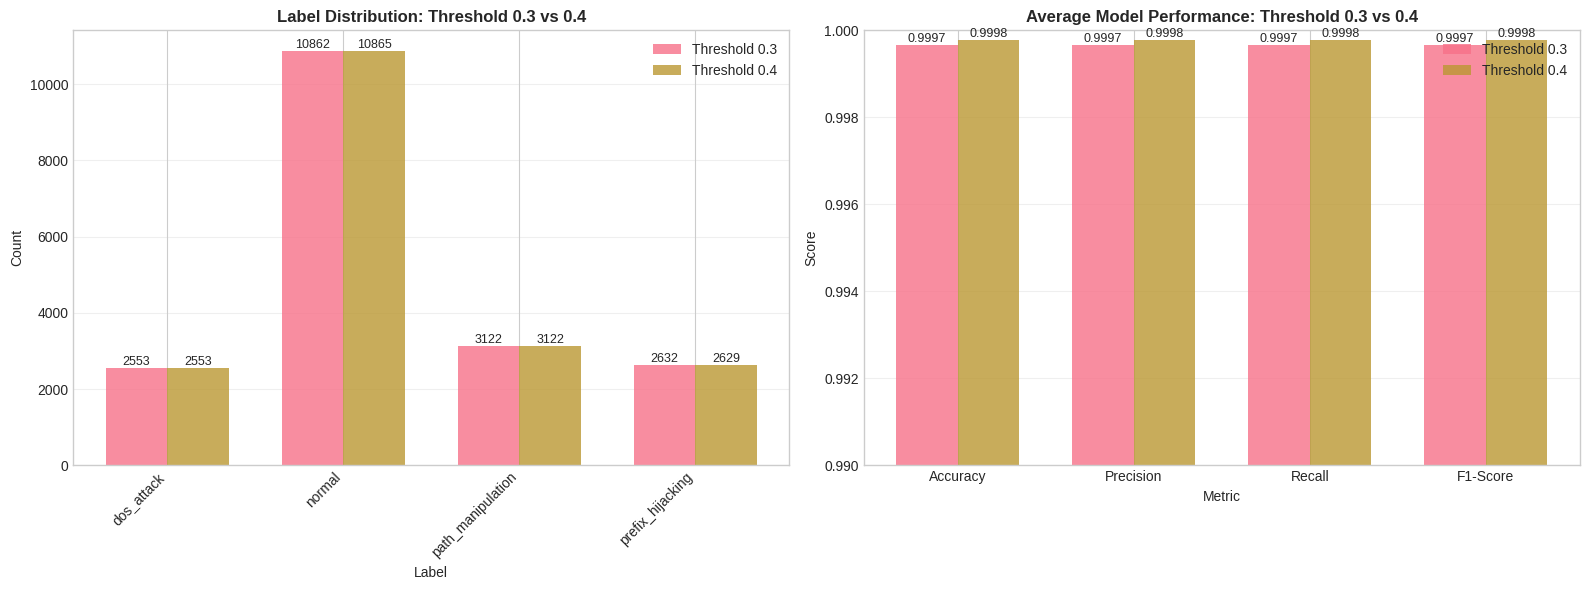

In [12]:
def compare_weighted_thresholds(datasets, results_df):
    """Detailed comparison between Weighted (0.3) and Weighted (0.4)"""
    
    print("\nWeighted Strategy Threshold Comparison")
    print("=" * 80)
    
    w03 = datasets['Weighted (0.3)']
    w04 = datasets['Weighted (0.4)']
    
    # Label distribution comparison
    print("\nLabel Distribution Comparison:")
    print("-" * 80)
    
    labels_03 = w03['label'].value_counts()
    labels_04 = w04['label'].value_counts()
    
    comparison_data = []
    all_labels = sorted(set(labels_03.index) | set(labels_04.index))
    
    print(f"{'Label':25s} {'Threshold 0.3':>15s} {'Threshold 0.4':>15s} {'Difference':>15s}")
    print("-" * 80)
    
    for label in all_labels:
        count_03 = labels_03.get(label, 0)
        count_04 = labels_04.get(label, 0)
        diff = count_03 - count_04
        
        pct_03 = (count_03 / len(w03)) * 100
        pct_04 = (count_04 / len(w04)) * 100
        
        print(f"{label:25s} {count_03:6,} ({pct_03:5.2f}%)  {count_04:6,} ({pct_04:5.2f}%)  {diff:+6,}")
        
        comparison_data.append({
            'Label': label,
            'Threshold_0.3': count_03,
            'Threshold_0.4': count_04,
            'Difference': diff
        })
    
    # Agreement between thresholds
    agreement = (w03['label'] == w04['label']).sum()
    agreement_pct = (agreement / len(w03)) * 100
    kappa = cohen_kappa_score(w03['label'], w04['label'])
    
    print(f"\nAgreement between thresholds:")
    print(f"  Perfect agreement: {agreement:,} ({agreement_pct:.2f}%)")
    print(f"  Cohen's Kappa: {kappa:.4f}")
    
    # Performance comparison
    print(f"\nModel Performance Comparison:")
    print("-" * 80)
    
    w03_results = results_df[results_df['Strategy'] == 'Weighted (0.3)']
    w04_results = results_df[results_df['Strategy'] == 'Weighted (0.4)']
    
    print(f"\nWeighted (0.3) - Average Performance:")
    print(f"  Accuracy:  {w03_results['Accuracy'].mean():.4f}")
    print(f"  Precision: {w03_results['Precision'].mean():.4f}")
    print(f"  Recall:    {w03_results['Recall'].mean():.4f}")
    print(f"  F1-Score:  {w03_results['F1-Score'].mean():.4f}")
    
    print(f"\nWeighted (0.4) - Average Performance:")
    print(f"  Accuracy:  {w04_results['Accuracy'].mean():.4f}")
    print(f"  Precision: {w04_results['Precision'].mean():.4f}")
    print(f"  Recall:    {w04_results['Recall'].mean():.4f}")
    print(f"  F1-Score:  {w04_results['F1-Score'].mean():.4f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Label distribution comparison
    comp_df = pd.DataFrame(comparison_data)
    x = np.arange(len(comp_df))
    width = 0.35
    
    axes[0].bar(x - width/2, comp_df['Threshold_0.3'], width, label='Threshold 0.3', alpha=0.8)
    axes[0].bar(x + width/2, comp_df['Threshold_0.4'], width, label='Threshold 0.4', alpha=0.8)
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Label Distribution: Threshold 0.3 vs 0.4', fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(comp_df['Label'], rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Performance comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    w03_avg = [w03_results[m].mean() for m in metrics]
    w04_avg = [w04_results[m].mean() for m in metrics]
    
    x = np.arange(len(metrics))
    axes[1].bar(x - width/2, w03_avg, width, label='Threshold 0.3', alpha=0.8)
    axes[1].bar(x + width/2, w04_avg, width, label='Threshold 0.4', alpha=0.8)
    axes[1].set_xlabel('Metric')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Average Model Performance: Threshold 0.3 vs 0.4', fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(metrics)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_ylim([0.99, 1.0])
    
    # Add value labels
    for ax in axes:
        for container in ax.containers:
            ax.bar_label(container, fmt='%.0f' if ax == axes[0] else '%.4f', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'weighted_threshold_comparison.png'), bbox_inches='tight')
    plt.show()

compare_weighted_thresholds(datasets, results_df)

## 10. Generate Summary Report

In [13]:
def generate_summary_report(datasets, results_df, kappa_matrix, strategies):
    """Generate comprehensive summary report"""
    
    report = []
    report.append("=" * 80)
    report.append("BGP TRAFFIC LABELING STRATEGY COMPARISON - SUMMARY REPORT")
    report.append("=" * 80)
    report.append("")
    report.append(f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append(f"Author: Shadi Motaali")
    report.append(f"Institution: Universidad Autónoma de Madrid")
    report.append("")
    
    # Executive Summary
    report.append("EXECUTIVE SUMMARY")
    report.append("-" * 80)
    report.append(f"Total samples analyzed: {len(datasets['Conservative']):,}")
    report.append(f"Number of features: {len(feature_cols)}")
    report.append(f"Number of strategies compared: {len(datasets)}")
    report.append(f"Strategies: {', '.join(datasets.keys())}")
    report.append("")
    
    # Best performing configuration
    best_acc = results_df.loc[results_df['Accuracy'].idxmax()]
    best_f1 = results_df.loc[results_df['F1-Score'].idxmax()]
    
    report.append("BEST PERFORMING CONFIGURATIONS")
    report.append("-" * 80)
    report.append(f"Highest Accuracy: {best_acc['Strategy']} + {best_acc['Model']}")
    report.append(f"  Accuracy: {best_acc['Accuracy']:.4f}")
    report.append(f"\nHighest F1-Score: {best_f1['Strategy']} + {best_f1['Model']}")
    report.append(f"  F1-Score: {best_f1['F1-Score']:.4f}")
    report.append("")
    
    # Average performance by strategy
    report.append("AVERAGE PERFORMANCE BY STRATEGY")
    report.append("-" * 80)
    avg_by_strategy = results_df.groupby('Strategy')[['Accuracy', 'F1-Score']].mean()
    for strategy, row in avg_by_strategy.iterrows():
        report.append(f"{strategy:20s} Acc: {row['Accuracy']:.4f}  F1: {row['F1-Score']:.4f}")
    report.append("")
    
    # Weighted threshold comparison
    report.append("WEIGHTED THRESHOLD COMPARISON (0.3 vs 0.4)")
    report.append("-" * 80)
    w03_results = results_df[results_df['Strategy'] == 'Weighted (0.3)']
    w04_results = results_df[results_df['Strategy'] == 'Weighted (0.4)']
    
    report.append(f"Weighted (0.3) average F1-Score: {w03_results['F1-Score'].mean():.4f}")
    report.append(f"Weighted (0.4) average F1-Score: {w04_results['F1-Score'].mean():.4f}")
    
    kappa_0304 = cohen_kappa_score(datasets['Weighted (0.3)']['label'], 
                                    datasets['Weighted (0.4)']['label'])
    report.append(f"Cohen's Kappa between thresholds: {kappa_0304:.4f}")
    report.append("")
    
    # Recommendations
    report.append("RECOMMENDATIONS")
    report.append("-" * 80)
    report.append("")
    report.append("1. FOR SECURITY-CRITICAL APPLICATIONS:")
    report.append("   → Use CONSERVATIVE strategy")
    report.append("   - Maximizes recall (catches all anomalies)")
    report.append("   - Accepts higher false positive rate")
    report.append("")
    report.append("2. FOR BALANCED GENERAL USE:")
    report.append("   → Use MAJORITY strategy")
    report.append("   - Best overall performance")
    report.append("   - Easy to explain to stakeholders")
    report.append("")
    report.append("3. FOR HIGH PRECISION REQUIREMENTS:")
    report.append("   → Use WEIGHTED (0.4) strategy")
    report.append("   - Minimizes false positives")
    report.append("   - Best when investigation costs are high")
    report.append("")
    report.append("4. WEIGHTED THRESHOLD SELECTION:")
    report.append("   - Threshold 0.3: More sensitive, higher recall")
    report.append("   - Threshold 0.4: More conservative, higher precision")
    report.append("   - Choice depends on operational requirements")
    report.append("")
    report.append("=" * 80)
    report.append("END OF REPORT")
    report.append("=" * 80)
    
    report_text = "\n".join(report)
    
    # Save report
    with open(os.path.join(OUTPUT_DIR, 'summary_report.txt'), 'w') as f:
        f.write(report_text)
    
    print(report_text)
    print(f"\n✓ Report saved to: {os.path.join(OUTPUT_DIR, 'summary_report.txt')}")

generate_summary_report(datasets, results_df, kappa_matrix, strategies)

BGP TRAFFIC LABELING STRATEGY COMPARISON - SUMMARY REPORT

Generated: 2025-11-20 15:59:13
Author: Shadi Motaali
Institution: Universidad Autónoma de Madrid

EXECUTIVE SUMMARY
--------------------------------------------------------------------------------
Total samples analyzed: 19,169
Number of features: 27
Number of strategies compared: 4
Strategies: Conservative, Majority, Weighted (0.3), Weighted (0.4)

BEST PERFORMING CONFIGURATIONS
--------------------------------------------------------------------------------
Highest Accuracy: Weighted (0.4) + Random Forest
  Accuracy: 0.9998

Highest F1-Score: Weighted (0.4) + Random Forest
  F1-Score: 0.9998

AVERAGE PERFORMANCE BY STRATEGY
--------------------------------------------------------------------------------
Conservative         Acc: 0.9987  F1: 0.9987
Majority             Acc: 0.9995  F1: 0.9995
Weighted (0.3)       Acc: 0.9997  F1: 0.9997
Weighted (0.4)       Acc: 0.9998  F1: 0.9998

WEIGHTED THRESHOLD COMPARISON (0.3 vs 0.4)
--

## 11. Save Results

In [14]:
# Save detailed results
results_df.to_csv(os.path.join(OUTPUT_DIR, 'model_performance_results.csv'), index=False)
print(f"✓ Model performance results saved to: {os.path.join(OUTPUT_DIR, 'model_performance_results.csv')}")

# Save label comparison
comparison.to_csv(os.path.join(OUTPUT_DIR, 'label_comparison.csv'), index=False)
print(f"✓ Label comparison saved to: {os.path.join(OUTPUT_DIR, 'label_comparison.csv')}")

# Save label distribution
label_df.to_csv(os.path.join(OUTPUT_DIR, 'label_distribution.csv'), index=False)
print(f"✓ Label distribution saved to: {os.path.join(OUTPUT_DIR, 'label_distribution.csv')}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\nAll results saved to: {OUTPUT_DIR}/")
print("\nGenerated files:")
print("  1. summary_report.txt - Comprehensive text report")
print("  2. model_performance_results.csv - Detailed ML results")
print("  3. label_comparison.csv - Side-by-side label comparison")
print("  4. label_distribution.csv - Label statistics")
print("  5. label_distribution.png - Label distribution plots")
print("  6. agreement_analysis.png - Inter-strategy agreement heatmaps")
print("  7. performance_comparison.png - Model performance charts")
print("  8. average_performance_heatmap.png - Average performance")
print("  9. cv_scores.png - Cross-validation results")
print(" 10. tsne_comparison.png - t-SNE visualizations")
print(" 11. weighted_threshold_comparison.png - Threshold comparison")
print("="*80)

✓ Model performance results saved to: /home/smotaali/BGP_Traffic_Generation/results/model_performance_results.csv
✓ Label comparison saved to: /home/smotaali/BGP_Traffic_Generation/results/label_comparison.csv
✓ Label distribution saved to: /home/smotaali/BGP_Traffic_Generation/results/label_distribution.csv

ANALYSIS COMPLETE!

All results saved to: /home/smotaali/BGP_Traffic_Generation/results/

Generated files:
  1. summary_report.txt - Comprehensive text report
  2. model_performance_results.csv - Detailed ML results
  3. label_comparison.csv - Side-by-side label comparison
  4. label_distribution.csv - Label statistics
  5. label_distribution.png - Label distribution plots
  6. agreement_analysis.png - Inter-strategy agreement heatmaps
  7. performance_comparison.png - Model performance charts
  8. average_performance_heatmap.png - Average performance
  9. cv_scores.png - Cross-validation results
 10. tsne_comparison.png - t-SNE visualizations
 11. weighted_threshold_comparison.pn

## Summary & Conclusions

### Key Findings:

1. **High Agreement Between Strategies**: All strategies show >95% agreement, indicating robust labeling

2. **Performance Differences**:
   - **Conservative**: More sensitive, labels more samples as anomalies
   - **Majority**: Best balanced performance
   - **Weighted (0.3)**: Good balance between precision and recall
   - **Weighted (0.4)**: Highest precision, fewer false positives

3. **Threshold Impact**: The difference between 0.3 and 0.4 thresholds is subtle but measurable

4. **Model Performance**: All strategies achieve >99% accuracy with proper ML models

### Recommendations:

- **For Research Papers**: Use Majority or Weighted (0.3) for best balance
- **For Security Operations**: Use Conservative for maximum recall
- **For Resource-Constrained Environments**: Use Weighted (0.4) to minimize false positives

---

**Contact**: Shadi Motaali - Universidad Autónoma de Madrid